In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

# dataset

In [3]:
# import numpy as np

# mnist_data = np.load('archive/tn-for-unsup-ml/data/binarized_mnist.npz')
# train_data = torch.from_numpy(mnist_data['train_data'])
# test_data = torch.from_numpy(mnist_data['test_data'])

In [2]:
from train_base import *
statisticinfo= torch.load("/media/tianning/DATA/DATASET/MNIST/MNIST/statisitc_stdmean.pt")
statistic_std= statisticinfo['statisitc_std']
statistic_mean=statisticinfo['statisitc_mean']
transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x:(x-statistic_mean)/statistic_std,
    transforms.CenterCrop(24)
])
DATAPATH    = '/media/tianning/DATA/DATASET/MNIST/'
mnist_train = datasets.MNIST(DATAPATH, train=True, download=False, transform=transform)
mnist_test  = datasets.MNIST(DATAPATH, train=False,download=False, transform=transform)

In [6]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=60000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=128, shuffle=False)

In [14]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=60000, shuffle=True)

In [29]:
all_image = iter(train_loader).next()[0]

In [4]:
from mltool.visualization import *

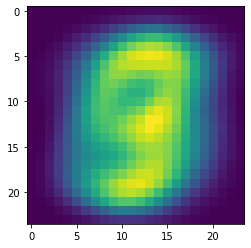

In [30]:
%matplotlib inline
plt.imshow(torch.sum(all_image[:,0]>0,0).numpy()) 

# Model

### Simple MPS layer

In [3]:
class MPSLinear(nn.Module):
    '''
    For a naive Linear Layer(in_features,out_features,
                             in_physics_bond = 2, out_physics_bond=2, virtual_bond_dim=2, 
                             bias=True,label_position='center',init_std=1e-10
                                       ): 
        input  (B, in_features)
        output (B, out_features)
    For s simplest MPSLayer(in_features: int, out_features: int, 
                            in_physics_bond: int, out_physics_bond: int, virtual_bond_dim:int,
                            bias: bool = True, label_position: int or str): 
        input  (B, in_features , in_physics_bond)
        output (B, out_features,out_physics_bond)
    '''
    def __init__(self, in_features,out_features,
                                       in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=2, 
                                       bias=True,label_position='center',init_std=1e-10):
        super(MPSLinear, self).__init__()
        if label_position is 'center':
            label_position = in_features//2
        assert type(label_position) is int
        self.in_features   = in_features
        self.out_features  = out_features
        self.vbd           = virtual_bond_dim
        self.ipb           = in_physics_bond
        self.opb           = out_physics_bond
        self.hn            = label_position
        left_num           = self.hn
        right_num          = in_features - left_num

        bias_mat = torch.eye(self.vbd).unsqueeze(-1).repeat(1,1,self.ipb)
        self.left_tensors = nn.Parameter(init_std * torch.randn(left_num         ,self.vbd,self.vbd, self.ipb)+ bias_mat)
        self.rigt_tensors = nn.Parameter(init_std * torch.randn(right_num        ,self.vbd,self.vbd, self.ipb)+ bias_mat)
        
        bias_mat = torch.eye(self.vbd).unsqueeze(-1).repeat(1,1,self.opb)
        self.cent_tensors = nn.Parameter(init_std * torch.randn(self.out_features,self.vbd,self.vbd, self.opb)+ bias_mat)
        
    @staticmethod
    def get_chain_contraction_fast(tensor):
        size   = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
        return tensor.squeeze(0)
    
    @staticmethod
    def get_chain_contraction_memory_save(tensor):
        size      = int(tensor.shape[0])
        now_tensor= tensor[0]
        for next_tensor in tensor[1:]:
            now_tensor = torch.einsum("bik,bkj->bij",now_tensor, next_tensor)
        return now_tensor
    
    def get_chain_contraction(self,tensor):
        size   = int(tensor.shape[0])
        D      = int(tensor.shape[-1])
        print(size)
        print(D)
        if D>30:
            return self.get_chain_contraction_memory_save(tensor)
        else:
            return self.get_chain_contraction_fast(tensor)
    
    def forward(self, input_data):
        # the input data shape is (B,L,pd)
        # expand to convolution patch
        embedded_data= input_data
        left_tensors = torch.einsum('wijp,nwp->wnij',self.left_tensors,embedded_data[:,:self.hn])#i.e. (K,NB,b,b)
        rigt_tensors = torch.einsum('wijp,nwp->wnij',self.rigt_tensors,embedded_data[:,-self.hn:])#i.e.(K,NB,b,b)

        left_tensors = self.get_chain_contraction(left_tensors) #i.e. (NB,b,b)
        rigt_tensors = self.get_chain_contraction(rigt_tensors) #i.e. (NB,b,b)

        tensor  = torch.einsum('bip,oplt,bli->bot',left_tensors,self.cent_tensors,rigt_tensors)
        # (NB,b,b) <-> (T,b,b,o) <-> (NB,b,b) ==> (NB,T,t)
        return tensor

In [4]:
import tensornetwork as tn
from tensornetwork import contractors
tn.set_default_backend("pytorch")
class MPSLinear_tn_loop(nn.Module):
    '''
    For s simplest MPSLayer(in_features: int, out_features: int,
                            in_physics_bond: int, 
                            out_physics_bond: int, virtual_bond_dim:int,
                            bias: bool = True, label_position: int or str):
        input  (B, in_features , in_physics_bond)
        output (B, out_features)
    '''
    def __init__(self, in_features,out_features,
                       in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=2,
                       bias=True,label_position='center',init_std=1e-10,**kargs):
        super().__init__()

        if label_position is 'center':
            label_position = in_features//2
        assert type(label_position) is int
        self.in_features   = in_features
        self.out_features  = out_features
        self.vbd           = virtual_bond_dim
        self.ipb           = in_physics_bond
        self.opb           = out_physics_bond
        self.hn            = label_position
        
        left_num           = self.hn
        right_num          = in_features - left_num

        bias_mat     = torch.eye(self.ipb,self.vbd)
        left_end     = init_std * torch.randn(self.ipb,self.vbd) + bias_mat

        bias_mat     = torch.eye(self.vbd, self.ipb)
        right_end    = init_std * torch.randn(self.vbd, self.ipb)+ bias_mat

        bias_mat     = torch.eye(self.vbd).unsqueeze(1).repeat(1,self.ipb,1)
        left_tensors = init_std * torch.randn(left_num-1 ,self.vbd, self.ipb , self.vbd)+ bias_mat
        rigt_tensors = init_std * torch.randn(right_num-1,self.vbd, self.ipb,self.vbd)+ bias_mat


        bias_mat     = torch.eye(self.vbd).unsqueeze(1).repeat(1,self.out_features,1)
        cent_tensors = init_std * torch.randn(self.vbd,self.out_features,self.vbd)+ bias_mat

        mps_var      = [left_end] + list(left_tensors)  + [cent_tensors] + list(rigt_tensors) + [right_end]
        self.mps_var = [nn.Parameter(v) for v in mps_var]
        self.center  = left_num
        for i, v in enumerate(self.mps_var):
            self.register_parameter(f'mps{i}', param=v)

    def contract_mps_with_input(self,input):
        assert len(input) == len(self.mps_var)-1
        mps_list_1   = self.mps_var
        mps_nodes_1  = [tn.Node(v, name=f"t{i}") for i,v in enumerate(mps_list_1)]
        mps_edges_1  = [mps_nodes_1[i][-1]^mps_nodes_1[i+1][0] for i in range(len(mps_nodes_1)-1)]
        inp_nodes    = [tn.Node(v, name=f"i{i}") for i,v in enumerate(input)]
        for i,input_node in enumerate(inp_nodes):
            j = i if i < self.center else i+1
            mps_physicd_edge = mps_nodes_1[j][0] if j==0 else mps_nodes_1[j][1]
            inp_physics_edge = input_node[0]
            tn.connect(mps_physicd_edge,inp_physics_edge,name=f"p_{i}")

        ans = contractors.auto(mps_nodes_1+inp_nodes,
                              output_edge_order=[mps_nodes_1[self.center][1]]).tensor
        return ans

    def forward(self, inputs):
        out = torch.stack([self.contract_mps_with_input(single_input) for single_input in inputs])
        return out
    
class MPSLinear_tn_batch(MPSLinear_tn_loop):
    def forward(self, inputs):
        num        = len(self.mps_var)
        mps_nodes  = [tn.Node(v, name=f"t{i}") for i,v in enumerate(self.mps_var)]
        mps_edges  = [mps_nodes[i][-1]^mps_nodes[i+1][0] for i in range(num-1)]


        inputs= inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
        out   = torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
        out   = out.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)
        out   = [v for v in out]
        out[0]= torch.diagonal(out[0], dim1=0, dim2=-1).transpose(1,0)#(B,k,B) -> #(B,k)

        inp_nodes=[tn.Node(v, name=f"i{i}") for i,v in enumerate(out)]
        inp_edges=[inp_nodes[0][0]^inp_nodes[1][0]]+ [
            inp_nodes[i][-1]^inp_nodes[i+1][0] for i in range(1,len(inp_nodes)-1)]

        for i,input_node in enumerate(inp_nodes):
            j = i if i < self.center else i+1
            mps_physicd_edge = mps_nodes[j][0] if j==0 else mps_nodes[j][1]
            inp_physics_edge = input_node[1]
            tn.connect(mps_physicd_edge,inp_physics_edge,name=f"p_{i}")

        ans = contractors.auto(mps_nodes+inp_nodes,output_edge_order=[inp_nodes[-1][2],mps_nodes[self.center][1]]).tensor
        return ans

In [91]:
model = MPSLinear_tn_loop(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=10,
                  bias=False,label_position='center',init_std=1e-2)

In [88]:
model = MPSLinear_tn_batch(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=10,
                  bias=False,label_position='center',init_std=1e-2)

In [92]:
_input = torch.randn(2,28*28,2)

### AMPS

In [79]:
#from models.amps import AMPSShare
class AMPSShare(nn.Module):
    '''
    This version may fast, but will cost much more memory
    n        : the length of input tensor sequence
    bond_dim : the virtual bond dim. The capacity of model.
    phys_dim : the feature/class number
    ------------------------------
    Input:  any data/spin configurations, shape: (B, n ,phys_dim)
    Output: prob_matrix of each sample, shape: (B, n, phys_dim), pass softmax to get probility.
    -------------------------------
    Weight Cost:
        n * bond_dim * bond_dim * phys_dim
    '''
    def __init__(self, n=784, bond_dim=10, phys_dim=2,std=1e-8):
        super(AMPSShare, self).__init__()
        # Initialize AMPS model parameters, which is a (n, D, D, 2) tensor
        self.register_buffer('bias_mat', torch.eye(bond_dim).unsqueeze(-1).repeat(1,1,phys_dim))
        # bias_mat: which is realy important when n>>1
        self.tensors = nn.Parameter(std * torch.randn(n, bond_dim, bond_dim, phys_dim)+self.bias_mat)
        # Set attributes
        self.n = n
        self.bond_dim = bond_dim
        self.std = std

    def forward(self, embedded_data):

        bs = embedded_data.shape[0]
        # local feature map, x_j -> [x_j, 1-x_j]
        #-> embedded_data = torch.stack([data, 1.0 - data], dim=2)  # (bs, n, 2)
        ##logx_hat = torch.zeros_like(embedded_data)
        ##logx_hat[:, 0, :] = F.log_softmax(self.tensors[0, 0, 0], dim=0)
        prob_matrix = self.tensors[0, 0, 0].repeat((bs,1)).unsqueeze(1) # (bs,1,2)
        mats = torch.einsum('lri,bi->blr', self.tensors[0] , embedded_data[:, 0, :])
        left_vec = mats[:, 0:1, :]  # (bs,  D)
        for idx in range(1, self.n):
            # compute p(s_2 | s_1) and so on
            logits = torch.einsum('br, ri->bi', left_vec.squeeze(1),self.tensors[idx,:,0,:])
            #(bs,D) <-> (D,2) ->(bs,2)
            prob_matrix = torch.cat([prob_matrix,logits.unsqueeze(1)], dim=1)
            #(bs, n-2, 2) + (bs,1,2) -> (bs, n-1, 2)
            ##logx_hat[:, idx, :] = F.log_softmax(logits, dim=1)
            mats = torch.einsum('lri,bi->blr', self.tensors[idx, :, :, :] , embedded_data[:, idx, :])
            #(D,D,2) <-> (bs,2) ->(bs,D,D)
            left_vec = torch.bmm(left_vec, mats)  # (bs, 1, D)
        # compute log prob
        return prob_matrix


### PEPS

In [4]:
from models.two_dim_model import *

In [194]:
a= torch.randn(10,6,6,16)
model(a).shape

torch.Size([10, 16])

#### naive contractor: face dimenstion explore

In [3]:
import torch

In [7]:
# import torch
# tensor = torch.randn(8,8,6,6,6,6)
# while tensor.shape[0]>2:
#     print(tensor.shape)
#     lu_tensor = tensor[0::2,0::2]
#     ld_tensor = tensor[0::2,1::2]
#     ru_tensor = tensor[1::2,0::2]
#     rd_tensor = tensor[1::2,1::2]
#     tensor     = torch.einsum("xyabcd,xyhdij,xycefg,xyigkl->xyahbefkjl",
#                             lu_tensor,
#                             ld_tensor,
#                             ru_tensor,
#                             rd_tensor).flatten(4,5).flatten(-4,-3).flatten(2,3).flatten(-2,-1)

##### cotengra

In [ ]:
from tensornetwork.contractors.opt_einsum_paths.utils import *
from opt_einsum.paths import greedy

In [ ]:
import opt_einsum as oe
import tensornetwork as tn
tn.set_default_backend("pytorch")

In [1]:
import torch
import opt_einsum as oe
import tensornetwork as tn
tn.set_default_backend("pytorch")
    from tensornetwork.contractors.opt_einsum_paths.utils import *
tensor = torch.randn(16,16,2,2,2,2).cuda()

node_array = []
W,H = tensor.shape[:2]
for i in range(W):
    node_line = []
    for j in range(H):
        node = tn.Node(tensor[i][j],name=f"{i}-{j}")
        node_line.append(node)
    node_array.append(node_line)

for i in range(W):
    for j in range(H):
        if j==H-1:tn.connect(node_array[i][j][2],node_array[i  ][0  ][0],f"{i}{j}<->{i}{0}")
        else:     tn.connect(node_array[i][j][2],node_array[i  ][j+1][0],f"{i}{j}<->{i}{j+1}")
        if i==W-1:tn.connect(node_array[i][j][3],node_array[0  ][j  ][1],f"{i}{j}<->{0}{j}")
        else:     tn.connect(node_array[i][j][3],node_array[i+1][j  ][1],f"{i}{j}<->{i+1}{j}")

node_list = [item for sublist in node_array for item in sublist]
nodes = node_list
input_sets = [set(node.edges) for node in nodes]
output_set = get_subgraph_dangling(nodes)
size_dict = {edge: edge.dimension for edge in get_all_edges(nodes)}

operands = []
for node,edge_label in zip(node_list,input_sets):
    operands+=[node.tensor,[edge.name for edge in edge_label]]

path,info = oe.contract_path(*operands)

small_cores =[node.tensor for node in node_list]
import tqdm as tqdm
import cotengra as ctg

sf = ctg.SliceFinder(info, target_size=2**27)
inds_to_slice, cost_of_slicing = sf.search()

In [17]:
import tqdm as tqdm
import cotengra as ctg

sf = ctg.SliceFinder(info, target_size=2**27)
inds_to_slice, cost_of_slicing = sf.search()

In [18]:
print(cost_of_slicing.size    ) # the new largest intermediate
print(cost_of_slicing.overhead)  # theoretical 'slowdown'

67108864
2.9753197715379116


In [19]:
sc = sf.SlicedContractor([*small_cores])
result = sum(sc.contract_slice(i) for i in tqdm.trange(sc.nslices))
# 100%|██████████| 512/512 [00:55<00:00,  9.30it/s]



  0%|          | 0/262144 [00:00<?, ?it/s]

  0%|          | 15/262144 [00:00<30:05, 145.21it/s]

  0%|          | 30/262144 [00:00<44:00, 99.28it/s] 

  0%|          | 41/262144 [00:00<47:41, 91.58it/s]

  0%|          | 51/262144 [00:00<49:42, 87.88it/s]

  0%|          | 60/262144 [00:00<50:56, 85.76it/s]

  0%|          | 69/262144 [00:00<51:48, 84.32it/s]

  0%|          | 78/262144 [00:00<52:24, 83.35it/s]

  0%|          | 87/262144 [00:00<53:13, 82.06it/s]

  0%|          | 96/262144 [00:01<53:42, 81.31it/s]

  0%|          | 105/262144 [00:01<53:43, 81.29it/s]

  0%|          | 114/262144 [00:01<53:46, 81.21it/s]

  0%|          | 123/262144 [00:01<53:46, 81.20it/s]

  0%|          | 132/262144 [00:01<53:47, 81.19it/s]

  0%|          | 141/262144 [00:01<53:47, 81.18it/s]

  0%|          | 150/262144 [00:01<53:49, 81.13it/s]

  0%|          | 159/262144 [00:01<53:48, 81.14it/s]

  0%|          | 168/262144 [00:01<53:57, 80.91it/s]

  0%|          | 177/262144 [00:02<54:10, 8

KeyboardInterrupt: 

In [7]:
import torch
import opt_einsum as oe

In [ ]:
tensor = torch.randn(12,12,4,4,4,4)/2
#tensor     = torch.randn(2,2,16,16,16,16)/10
computer_vie_tn(tensor)

[(0, 8), (0, 7), (0, 7), (0, 6), (0, 5), (0, 4), (0, 3), (1, 2), (0, 1), (0, 9), (0, 8), (0, 8), (0, 7), (0, 6), (1, 5), (1, 4), (1, 3), (1, 4), (3, 13), (7, 12), (3, 11), (3, 10), (3, 9), (3, 8), (6, 7), (3, 6), (3, 5), (3, 4), (2, 6), (2, 10), (1, 11), (4, 11), (0, 13), (5, 12), (5, 12), (6, 12), (5, 12), (6, 11), (6, 11), (6, 12), (4, 12), (6, 13), (7, 14), (7, 13), (4, 12), (6, 11), (6, 11), (6, 10), (6, 10), (0, 11), (0, 11), (5, 10), (0, 9), (4, 9), (2, 9), (1, 8), (3, 7), (3, 7), (3, 9), (3, 9), (3, 10), (3, 10), (3, 9), (3, 8), (1, 7), (2, 6), (6, 7), (2, 6), (2, 5), (2, 5), (5, 17), (6, 18), (12, 21), (4, 23), (13, 22), (4, 21), (15, 23), (10, 23), (10, 22), (7, 27), (11, 27), (11, 27), (11, 26), (7, 29), (9, 29), (8, 28), (15, 29), (7, 28), (13, 29), (6, 31), (6, 30), (13, 29), (16, 29), (1, 20), (21, 26), (21, 25), (6, 24), (15, 30), (15, 29), (8, 28), (10, 27), (6, 27), (10, 26), (8, 25), (9, 24), (5, 23), (2, 21), (10, 25), (5, 24), (2, 23), (1, 33), (1, 21), (0, 31), (2, 

### arbitary partition

##### generate json file

In [22]:
from models.arbitary_shape.shapes_list import shape_24x24_1

In [5]:
from mltool.visualization import *

In [23]:
info_per_point = {}
info_per_group = {}
for i,line in enumerate(shape_24x24_1):
    for j,val in enumerate(line):
        info_per_point[(i,j)] = {'val':val}
def search_for(pos,group=None):
    i,j = pos
    val = info_per_point[pos]['val']
    if 'group' not in info_per_point[pos]:
        if group is None:group=len(info_per_group)
        info_per_point[pos]['group']=group
        if group not in info_per_group:info_per_group[group]={'element':[],'neighbor':set()}
        info_per_group[group]['element'].append((i,j))
        for neighbor in [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]:    
            if (neighbor in info_per_point):
                neighbor_val = info_per_point[neighbor]['val']
                if ('group' not in info_per_point[neighbor]) and (val == neighbor_val):
                    search_for(neighbor,group)

In [24]:
for i,line in enumerate(shape_24x24_1):
    for j,val in enumerate(line):
        search_for((i,j))

In [25]:
info_per_line={}
for i,line in enumerate(shape_24x24_1):
    for j,val in enumerate(line):
        group_now = info_per_point[(i,j)]['group']
        for neighbor in [(i-1,j),(i+1,j),(i,j-1),(i+1)]:
            if neighbor in info_per_point:
                neighbor_group = info_per_point[neighbor]['group']
                if neighbor_group!=group_now:
                    info_per_group[group_now]['neighbor']=info_per_group[group_now]['neighbor']|set([neighbor_group])
                    line_tuple = [group_now,neighbor_group]
                    line_tuple.sort() 
                    line_tuple= tuple(line_tuple)
                    if line_tuple not in info_per_line:
                        info_per_line[line_tuple]={"element":[]}
                    linepos=[(i,j),neighbor]
                    linepos.sort() 
                    info_per_line[line_tuple]["element"].append(linepos)

In [26]:
center = np.array([(0+23)/2,(0+23)/2]) 
for line,pool in info_per_line.items():
    start_pos=np.array([a for a,b in pool['element']])
    ended_pos=np.array([b for a,b in pool['element']])
    start_pos=np.mean(start_pos,0)
    ended_pos=np.mean(ended_pos,0)
    centr_pos=(start_pos + ended_pos)/2
    
    info_per_line[line]['weight']    = np.linalg.norm(centr_pos-center)
    info_per_line[line]['start_pos'] = list(start_pos)
    info_per_line[line]['ended_pos'] = list(ended_pos)
    info_per_line[line]['centr_pos'] = list(centr_pos)

In [27]:
MAX_Dimension = 12
MIN_Dimension = 3
weight_list  = [val['weight'] for val in info_per_line.values()]
max_distance = max(weight_list)
min_distance = min(weight_list)
Dimenstion_function = lambda x : np.floor((MIN_Dimension-MAX_Dimension)/(max_distance-min_distance)*(x-min_distance)+MAX_Dimension)

for line,pool in info_per_line.items():
    info_per_line[line]['D']    = Dimenstion_function(info_per_line[line]['weight'])

for group in info_per_group.keys():
    info_per_group[group]['neighbor']=list(info_per_group[group]['neighbor'])

for group,info in info_per_group.items():
    info_per_group[group]['element_idx']=np.ravel_multi_index(np.array(info['element']).transpose(),(24,24)).tolist()

In [32]:
import torch

arbitary_shape_state_dict={}
arbitary_shape_state_dict['node']   =info_per_group
arbitary_shape_state_dict['line']   =info_per_line
arbitary_shape_state_dict['element']=info_per_point
torch.save(arbitary_shape_state_dict,"models/arbitary_shape/arbitary_shape_2.json")

##### plot

In [86]:
import plotly.graph_objects as go
import numpy as np

In [87]:
objects = []
offsite = 0.5
scalar  = 4
for (g_l,g_r), pool in info_per_line.items():
    start_pos=pool['start_pos']
    ended_pos=pool['ended_pos']
    D = pool['D']
    x0,y0  = scalar*start_pos
    x1,y1  = scalar*ended_pos
    objects.append(go.Scatter(x=[x0,x1],y=[y0,y1],mode='lines', fill="toself",
                          text=f"D={D}",hoveron='points',hoverinfo='text'
                             )
                  )

for group, pool in info_per_group.items():
    xes,yes=np.array(pool['element']).transpose()
    w = max(xes)-min(xes)
    h = max(yes)-min(yes)
    c_x = xes.mean()
    c_y = yes.mean()
    x0  = scalar*min(xes)-offsite
    x1  = scalar*max(xes)+offsite
    y0  = scalar*min(yes)-offsite
    y1  = scalar*max(yes)+offsite
    objects.append(go.Scatter(x=[x0,x0,x1,x1,x0],y=[y0,y1,y1,y0,y0],mode='lines',fill="toself",
                               hoveron='fills',hoverinfo='text',text=f"G={group}",
                              ))




In [92]:
fig = go.Figure()

axis = dict(showline=False, zeroline=False,showgrid=False,showticklabels=False,)
fig.update_layout(showlegend=False,xaxis=axis,yaxis=axis,plot_bgcolor='white')
fig.update_layout(
         autosize=False,
            width=900,
            height=900,
        hoverlabel=dict(
        bgcolor="white",
        font_size=16,
        font_family="Rockwell"
        )
)
fig.update_xaxes(fixedrange=True)
fig.update_yaxes(scaleanchor = "x",scaleratio = 1,)
#if show_name: self.depoly_label(fig)
for obj in objects:fig.add_trace(obj)
fig

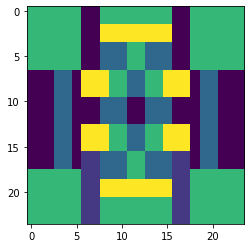

In [65]:
%matplotlib inline
plt.imshow(np.array(shape_24x24_1))

##### module

In [3]:
from models.tensornetwork_base import TN_Base
import torch.nn as nn

In [4]:
import opt_einsum as oe

In [ ]:
info_per_group=self.info_per_group
info_per_line =self.info_per_line 
info_per_point=self.info_per_point

In [5]:
class PEPS_einsum_arbitrary_partition_optim(TN_Base):
    def __init__(self,out_features=10,in_physics_bond = 2, virtual_bond_dim="models/arbitary_shape/arbitary_shape_1.json",
                       bias=True,label_position='center',init_std=1e-10,contraction_mode = 'recursion',seted_variation=10):
        super().__init__()
        if isinstance(virtual_bond_dim,str):
            arbitary_shape_state_dict = torch.load(virtual_bond_dim)
        else:
            arbitary_shape_state_dict = virtual_bond_dim
        assert isinstance(arbitary_shape_state_dict,dict)
        
        
        info_per_group = arbitary_shape_state_dict['node']
        info_per_line  = arbitary_shape_state_dict['line']
        info_per_point = arbitary_shape_state_dict['element']
        
        num_of_tensor   = len(info_per_group)
        list_of_virt_dim= [t['D'] for t in info_per_line.values()]
        list_of_phys_dim= [len(t['element']) for t in info_per_group.values()]
        divider         = np.prod([np.power(t,1/num_of_tensor) for t in list_of_phys_dim+list_of_virt_dim])
        solved_var      = np.power(seted_variation,1/num_of_tensor)/divider
        solved_std      = np.sqrt(solved_var)
        print(solved_std)
        
        center_group    = 0
        damgling_num    = len(info_per_group)
        info_per_group[center_group]['neighbor'].insert(0,damgling_num)
        info_per_line[(center_group,damgling_num)]={'D': out_features}

        self.info_per_group=info_per_group
        self.info_per_line =info_per_line
        self.info_per_point=info_per_point

        operands = []
        sublist_list=[]
        outlist  = [list(info_per_line.keys()).index((center_group,damgling_num))]
        ranks_list=[]
        for group_now in range(len(info_per_group)):
            group_info= info_per_group[group_now]
            neighbors = group_info['neighbor']
            ranks = []
            sublist=[]
            for neighbor_id in neighbors:
                line_tuple = [group_now,neighbor_id]
                line_tuple.sort()
                line_tuple= tuple(line_tuple)
                D = int(info_per_line[line_tuple]['D'])
                idx = list(info_per_line.keys()).index(line_tuple)
                ranks.append(D)
                sublist.append(idx)
            tensor = np.random.randn(*ranks)
            operands+=[tensor,[*sublist]]

            ranks_list.append(ranks)
            sublist_list.append(sublist)
        operands+= [[...,*outlist]]
        path,info = oe.contract_path(*operands,optimize='random-greedy-128')

        self.path         = path
        self.sublist_list = sublist_list
        self.outlist      = outlist
    
        # assume all element for the tensornetwork is indenpendent. 
        # The bond (include physics) list is l0,l1,l2,...,ln
        # All element follow normal distribution X - sigma(0,alpha)
        # where alpha is the variation we need to calculated.
        # the output after contracting is also a tensor (may 1-rank scalar, 2-rank matrix, etc)
        # the element of the output follow the composite normal distribution Y - sigma(0,beta)
        # where beta = l0 x l1 x l2 x ... x ln x alpha^(# of tensor)
        
        unit_list = []
        for i in range(len(sublist_list)):
            shape = ranks_list[i]
            P        = len(info_per_group[i]['element'])
            control_mat = self.rde2D((P,*shape),0,physics_index=0,offset= 2 if i==center_group else 1)
            bias_mat    = torch.normal(0,solved_std,(P,*shape))
            bias_mat[control_mat.nonzero(as_tuple=True)]=0                           
            unit_list.append(control_mat+bias_mat)
            #unit_list.append(rdetemp((P,*shape),1 if i==center_group else None))
            #unit_list.append()
        assert len(unit_list)==len(sublist_list)

        self.unit_list = [nn.Parameter(v) for v in unit_list]
        for i, v in enumerate(self.unit_list):
            self.register_parameter(f'unit_{i}', param=v)

    def forward(self,input_data):
        #input data shape B,1,W,H
        assert len(input_data.shape)==4
        input_data  = input_data.flatten(-3,-1)

        _input = []
        for i,unit in enumerate(self.unit_list):
            patch_idx  = self.info_per_group[i]['element_idx']
            batch_input= input_data[...,patch_idx] # B,P
            batch_unit = torch.tensordot(batch_input,unit,dims=([-1], [0]))
            #print(f"{batch_input.norm()}-{unit.norm()}->{batch_unit.norm()}")
            _input.append(batch_unit)

        operands=[]
        for tensor,sublist in zip(_input,self.sublist_list):
            operand = [tensor,[...,*sublist]]
            operands+=operand
        operands+= [[...,*self.outlist]]
        return self.einsum_engine(*operands,optimize=self.path)


In [5]:
from models.two_dim_model import PEPS_einsum_uniform_shape_6x6_fast

In [6]:
model = PEPS_einsum_uniform_shape_6x6_fast(in_physics_bond=16)

In [10]:
for name,p in model.named_parameters():
    print(f"{name}:{p.grad.norm()}")

bulk_tensors:0.0005047222948633134
edge_tensors:7.03040132066235e-05
corn_tensors:4.461875050765229e-06
cent_tensors:3.6354849726194516e-06


In [8]:
a=torch.randn(10,6,6,16)
model(a).norm().backward()

### Deep model (with nonlienar layer)

In [4]:
from models.tensornetwork_base import TN_Base
import torch.nn as nn
from models.model_utils import *
from models.two_dim_model import *

###### the random set for tensornetwork

In [ ]:
#         num_of_edge     = (W-1)*H+(H-1)*W
#         num_of_unit     = W*H
#         solved_var      = np.power(set_var,1/num_of_unit)*np.power(1/virtual_bond_dim,num_of_edge/(num_of_unit))/in_physics_bond
#         solved_std      = np.sqrt(solved_var)
#         print(solved_std)
#         random_engine   = lambda shape:torch.normal(0,solved_std,shape)

###### test

In [150]:
W=H=10
LW = W//2
LH = H//2

In [151]:
index_matrix = torch.LongTensor([[[i,j] for j in range(W)] for i in range(H)])
bulk_index,edge_index,corn_index=PEPS_uniform_shape_symmetry_base.flatten_image_input(index_matrix)

flag_matrix = torch.zeros(W,H).long()
position_matrix = torch.zeros(W,H).long()

for n,(i,j) in enumerate(corn_index.numpy()):
    flag_matrix[i,j]=0
    position_matrix[i,j]=n
for n,(i,j) in enumerate(edge_index.numpy()):
    flag_matrix[i,j]=1
    position_matrix[i,j]=n
for n,(i,j) in enumerate(bulk_index.numpy()):
    flag_matrix[i,j]=2
    position_matrix[i,j]=n

flag_matrix     = flag_matrix
position_matrix = position_matrix

In [157]:
O=2;D=3;B=5
corn_tensors = torch.randn(4,B,O,D,D)
edge_tensors = torch.randn(2*(W-2)+2*(H-2),B,D,D,D)
bulk_tensors = torch.randn((W-2)*(H-2),B,D,D,D,D)

In [158]:
point_x = [0,0,1,1]
point_y = [0,1,1,0]
p       = part_idex[point_x,point_y]#(L,4,2)
indexrule=position_matrix[p[...,0],p[...,1]]
partrule =flag_matrix[p[...,0],p[...,1]][:,0]

In [159]:
L=3

In [160]:
point_x = [j for j in range(L)]
point_y = [L for j in range(L)]
p       = part_idex[point_x,point_y]#(L,4,2)
indexrule=position_matrix[p[...,0],p[...,1]]
partrule =flag_matrix[p[...,0],p[...,1]][:,0]
should = PEPS_uniform_shape_symmetry_base.pick_tensors(partrule,indexrule,corn_tensors,edge_tensors,bulk_tensors)

##### module

In [51]:
class PEPS_uniform_shape_symmetry_deep_model(PEPS_uniform_shape_symmetry_base):
    def __init__(self, nonlinear_layer=nn.Tanh(),
                       normlized_layer_module=nn.InstanceNorm3d,
                       init_std=1e-10,set_var=1,**kargs):
        super().__init__(**kargs)
        H = self.H
        W = self.W
        LW= self.LW
        LH= self.LH
        D = self.D
        O = self.O
        P = self.P
        num_of_edge     = (W-1)*H+(H-1)*W
        num_of_unit     = W*H
        solved_var      = np.power(set_var,1/num_of_unit)*np.power(1/D,num_of_edge/(num_of_unit))/P
        solved_std      = np.sqrt(solved_var)
        print(solved_std)
        random_engine   = lambda shape:torch.normal(0,solved_std,shape)
        self.corn_tensors = torch.nn.init.normal_(self.corn_tensors,mean=0.0, std=solved_std)
        self.edge_tensors = torch.nn.init.normal_(self.edge_tensors,mean=0.0, std=solved_std)
        self.bulk_tensors = torch.nn.init.normal_(self.bulk_tensors,mean=0.0, std=solved_std)
        
        flag_matrix     = self.flag_matrix
        position_matrix = self.position_matrix
        index_matrix    = self.index_matrix
        part_lu_idex = torch.rot90(index_matrix,k=0)[:LW,:LH]
        part_ru_idex = torch.rot90(index_matrix,k=1)[:LW,:LH]
        part_rd_idex = torch.rot90(index_matrix,k=2)[:LW,:LH]
        part_ld_idex = torch.rot90(index_matrix,k=3)[:LW,:LH]
        part_idex = torch.stack([part_lu_idex,
                                 part_ru_idex,
                                 part_rd_idex,
                                 part_ld_idex],-2)
        
        indexrules = []
        partrules  = []
        point_x = [0,0,1,1]
        point_y = [0,1,1,0]
        p       = part_idex[point_x,point_y]#(L,4,2)
        indexrule=position_matrix[p[...,0],p[...,1]]
        partrule =flag_matrix[p[...,0],p[...,1]][:,0]

        indexrules.append(indexrule)
        partrules.append(partrule)
        edge_contraction_path=[]
        for L in range(2,LW):
            indexrule={}
            partrule={}
            tn2D_shape_list = [[(D,D,D)]+[(D,D,D,D)]*(L-1)]
            path,sublist_list,outlist = get_best_path(tn2D_shape_list,store=path_recorder,type='sub')
            edge_contraction_path.append([path,sublist_list,outlist])
            point_x = [[j for j in range(L)],[L for j in range(L)]]
            point_y = [[L for j in range(L)],[j for j in range(L)]]
            p       = part_idex[point_x,point_y]#(2,L,4,2)
            indexrule['edge']= position_matrix[p[...,0],p[...,1]].transpose(0,1)
            partrule['edge'] = flag_matrix[p[...,0],p[...,1]][0][:,0]
            
            point_x = [L]
            point_y = [L]
            p       = part_idex[point_x,point_y]#(L,4,2)
            
            indexrule['cent']= position_matrix[p[...,0],p[...,1]]
            partrule['cent'] = flag_matrix[p[...,0],p[...,1]][:,0]
            
            indexrules.append(indexrule)
            partrules.append(partrule)
        self.indexrules = indexrules
        self.partrules  = partrules
        self.edge_contraction_path = edge_contraction_path
        self.nonlinear_layer = nonlinear_layer
        self.normlized_layers = nn.ModuleList([normlized_layer_module(O,affine=True) for _ in self.partrules])
        
    def forward(self,input_data):
        LH = self.LH
        LW = self.LW
        D  = self.D
        bulk_tensors,edge_tensors,corn_tensors = self.get_batch_contraction_network(input_data)
        corn_tensors = self.pick_tensors(self.partrules[0],self.indexrules[0],corn_tensors,edge_tensors,bulk_tensors)
        corn = self.einsum_engine("lkoab,lkcdb,lkefcg,lkgah->lkohedf",*corn_tensors).flatten(-4,-3).flatten(-2,-1)
        corn = self.nonlinear_layer(corn)# (4,B,O,D,D)
        corn = self.normlized_layers[0](corn.permute(1,2,0,3,4)).permute(2,0,1,3,4)
        #corn = corn/D**2
        for i,(partrule, indexrule) in enumerate(zip(self.partrules[1:],self.indexrules[1:])):
            path,sublist_list,outlist = self.edge_contraction_path[i]
            edge_tensors= self.pick_tensors(partrule['edge'],indexrule['edge'],corn_tensors,edge_tensors,bulk_tensors)
            cent_tensor = self.pick_tensors(partrule['cent'],indexrule['cent'],corn_tensors,edge_tensors,bulk_tensors)[0]
            L           = len(edge_tensors)
            operands    = structure_operands(edge_tensors,sublist_list,outlist)
            edge1,edge2 = self.einsum_engine(*operands,optimize=path).flatten(-L-L,-L-1).flatten(-L,-1)
            corn = self.einsum_engine("lkoab,lkcdb,lkefcg,lkgah->lkohedf",corn ,edge1,cent_tensor,edge2).flatten(-4,-3).flatten(-2,-1)
            corn = self.nonlinear_layer(corn)
            corn = self.normlized_layers[i+1](corn.permute(1,2,0,3,4)).permute(2,0,1,3,4)
            #corn = corn/D**(L+1)
        # corn now is a tensor (B,4,D^(L/2),D^(L/2))
        corn   = corn/D**(LW/3)
        corn   = self.einsum_engine("kvab,kxbc,kycd,kzda->kvxyz",*corn).flatten(-4,-1)# -> (B,O^4)
        
        return corn

In [52]:
model = PEPS_uniform_shape_symmetry_deep_model(W=6,H=6,virtual_bond_dim=5,in_physics_bond=16,
                                               nonlinear_layer=nn.Identity(),
                                               normlized_layer_module=nn.Identity)
#model.weight_init(method="Expecatation_Normalization")

0.06538302430059152


In [53]:
with torch.no_grad():
    x=torch.normal(mean=0,std=1,size=(1000,6,6,16));print(torch.std_mean(x))
    x=model(x);print(torch.std_mean(x))

(tensor(0.9999), tensor(-0.0018))
(tensor(0.0016), tensor(-3.4246e-05))


# Contractor Test perodic condition

In [24]:
D=4;L=H=W=5;B=10;
tn2D_shape_list = [[(D,D)]+[(D,D,D)]*(H-1)]+[[(D,D,D)]+[(D,D,D,D)]*(H-1)]*(W-1)

In [ ]:
path,sublist_list,outlist = get_best_path(tn2D_shape_list,store=path_recorder,type='sub')

In [21]:
import numpy as np
import torch
import tensornetwork as tn
import opt_einsum as oe
import os,json
from tensornetwork.network_components import get_all_nondangling,get_all_dangling
from tensornetwork.contractors.opt_einsum_paths.utils import get_subgraph_dangling,get_all_edges

In [29]:
equation   = "kab,kcdb,kefcg,kgha->khedf"
tensor_l   = [torch.randn(B,D,D) ,torch.randn(B,D,D,D),torch.randn(B,D,D,D,D),torch.randn(B,D,D,D)]
oe.contract_path(equation, *tensor_l)[0]
path = oe.contract_path(equation, *tensor_l)[0]
oe.contract(equation,*tensor_l,optimize=path).shape

torch.Size([10, 4, 4, 4, 4])

In [38]:
def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    x =  torch.autograd.Variable(x,requires_grad=True)
    return x

In [34]:
path_recorder={}

In [32]:
from models.model_utils import *

In [35]:
tn2D_shape_list = [[(D,D)]+[(D,D,D)]*(H-1)]+[[(D,D,D)]+[(D,D,D,D)]*(H-1)]*(W-1)
path,sublist_list,outlist = get_best_path(tn2D_shape_list,store=path_recorder,type='sub')

In [39]:
tensor_list     = [rd_engine(B,*l) for t in tn2D_shape_list for l in t]
operands=[]
for tensor,sublist in zip(tensor_list,sublist_list):
    operand = [tensor,[...,*sublist]]
    operands+=operand
operands+= [[...,*outlist]]

In [42]:
oe.contract(*operands,optimize=path).shape

torch.Size([10, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

#### test_the_TRG_on_even_number

In [23]:
# #%%writefile Contractor2D/test_the_TRG_on_even_number.py
# import torch
# from Contractor2D.utils import apply_SVD

# tensor = torch.randn(4,4,2,2,2,2)

# print(uniform_shape_tensor_contractor_tn(tensor))

# truncate= None
# lu_tensor = tensor[0::2,0::2]
# ld_tensor = tensor[0::2,1::2]
# ru_tensor = tensor[1::2,0::2]
# rd_tensor = tensor[1::2,1::2]
# lu_lu,lu_rd = apply_SVD(lu_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk ,kcd
# rd_lu,rd_rd = apply_SVD(rd_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk, kcd
# ld_ld,ld_ru = apply_SVD(ld_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
# ru_ld,ru_ru = apply_SVD(ru_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
# tensor1     = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",
#                             lu_rd,
#                             ld_ru,
#                             rd_lu,
#                             ru_ld)
# tensor2     = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",
#                            rd_rd,
#                            ru_ru.roll(-1,1),
#                            lu_lu.roll(shifts=(-1, -1), dims=(0, 1)),
#                            ld_ld.roll(-1,0))

# print(tensor1_and_tensor2_contractor_tn(tensor1,tensor2))

# #print(torch.einsum("abcd,cdab->",tensor1[0,0],tensor2[0,0]))
# left,right  = apply_SVD(tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# ABK,KCD
# lower,uppe  = apply_SVD(tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# # new_tensor  = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",
# #                            right,
# #                            uppe,
# #                            left.roll(shifts=-1,dims=0),
# #                            lower.roll(shifts=1,dims=1))
# new_tensor  = torch.einsum("whadi,whjba,whkcb,whdcl->whijkl",
#                            lower,
#                            right.roll(-1,1),
#                            uppe.roll(-1,1),
#                            left.roll(shifts=(-1, -1), dims=(0, 1))
#                            )
# print(uniform_shape_tensor_contractor_tn(new_tensor))

# torch.einsum("abn,nji,lkh,hdc,caw,wkj,ilm,mbd->",
#              lu_lu[0,0],lu_rd[0,0],
#              rd_lu[0,0],rd_rd[0,0],
#              ld_ld[0,0],ld_ru[0,0],
#              ru_ld[0,0],ru_ru[0,0])

# torch.einsum("abji,lkdc,jcak,dilb->",
#              torch.einsum("abn,nji->abji",lu_lu[0,0],lu_rd[0,0]),
#              torch.einsum("lkh,hdc->lkdc",rd_lu[0,0],rd_rd[0,0]),
#              torch.einsum("caw,wkj->jcak",ld_ld[0,0],ld_ru[0,0]),
#              torch.einsum("ilm,mbd->dilb",ru_ld[0,0],ru_ru[0,0]))

# torch.dist(torch.einsum("abn,nji->abji",lu_lu[0,0],lu_rd[0,0]),lu_tensor)

# torch.dist(torch.einsum("lkh,hdc->lkdc",rd_lu[0,0],rd_rd[0,0]),rd_tensor)

# torch.dist(torch.einsum("caw,wkj->jcak",ld_ld[0,0],ld_ru[0,0]),ld_tensor)

# torch.dist(torch.einsum("ilm,mbd->dilb",ru_ld[0,0],ru_ru[0,0]),ru_tensor)

# torch.dist(lu_tensor[0,0],tensor[0,0])

# torch.dist(rd_tensor[0,0],tensor[1,1])

# torch.dist(ld_tensor[0,0],tensor[0,1])

# torch.dist(ru_tensor[0,0],tensor[1,0])

# torch.einsum("abji,lkdc,jcak,dilb->",
#              torch.einsum("abn,nji->abji",lu_lu[0,0],lu_rd[0,0]),
#              torch.einsum("lkh,hdc->lkdc",rd_lu[0,0],rd_rd[0,0]),
#              torch.einsum("caw,wkj->jcak",ld_ld[0,0],ld_ru[0,0]),
#              torch.einsum("ilm,mbd->dilb",ru_ld[0,0],ru_ru[0,0]))

# torch.einsum("abcd,idjb,ckal,jlik->",lu_tensor[0,0],ld_tensor[0,0],ru_tensor[0,0],rd_tensor[0,0])

# torch.einsum("abcd,ciaj,ldkb,kjli->",lu_tensor[0,0],ld_tensor[0,0],ru_tensor[0,0],rd_tensor[0,0])

# tensor1 = tensor[0,0]
# tensor2 = tensor[0,1]
# tensor3 = tensor[1,0]
# tensor4 = tensor[1,1]
# torch.einsum("abcd,idjb,ckal,jlik->",tensor1,tensor2,tensor3,tensor4)

Writing Contractor2D/test_the_TRG_on_even_number.py


#### check_the_brdc_coding_on_even_number

In [24]:
# #%%writefile Contractor2D/check_the_brdc_coding_on_even_number.py
# import torch
# from Contractor2D.utils import apply_SVD

# tensor     = torch.randn(8,8,2,2,2,2)/2
# uniform_shape_tensor_contractor_tn(tensor)

# lu_lu_origin,lu_rd_origin = apply_SVD(tensor[0::2,0::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk ,kcd
# rd_lu_origin,rd_rd_origin = apply_SVD(tensor[1::2,1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ld_ld_origin,ld_ru_origin = apply_SVD(tensor[0::2,1::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# ru_ld_origin,ru_ru_origin = apply_SVD(tensor[1::2,0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda

# lu_lu,lu_rd = apply_SVD(bulk_tensor[0::2,0::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk ,kcd
# rd_lu,rd_rd = apply_SVD(bulk_tensor[1::2,1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ld_ld,ld_ru = apply_SVD(bulk_tensor[0::2,1::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# ru_ld,ru_ru = apply_SVD(bulk_tensor[1::2,0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda

# print(lu_lu.shape)
# print(rd_lu.shape)
# print(ld_ld.shape)
# print(ru_ld.shape)

# lu_lu_should = lu_lu_origin[:,:]    ;lu_rd_should =lu_rd_origin[:,:]
# rd_lu_should = rd_lu_origin[:-1,:-1];rd_rd_should =rd_rd_origin[:-1,:-1]
# ld_ld_should = ld_ld_origin[:,:-1]  ;ld_ru_should =ld_ru_origin[:,:-1]
# ru_ld_should = ru_ld_origin[:-1,:]  ;ru_ru_should =ru_ru_origin[:-1,:]

# print(lu_lu_should.shape)
# print(rd_lu_should.shape)
# print(ld_ld_should.shape)
# print(ru_ld_should.shape)

# print(torch.dist(lu_lu_should,lu_lu),torch.dist(lu_rd_should,lu_rd))
# print(torch.dist(rd_lu_should,rd_lu),torch.dist(rd_rd_should,rd_rd))
# print(torch.dist(ld_ld_should,ld_ld),torch.dist(ld_ru_should,ld_ru))
# print(torch.dist(ru_ld_should,ru_ld),torch.dist(ru_ru_should,ru_ru))

# # right_edge == bulk_tensor[-1]
# # down_edge  == bulk_tensor[:,-1]

# rd_lu_r,rd_rd_r = apply_SVD(right_edge[1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ru_ld_r,ru_ru_r = apply_SVD(right_edge[0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# rd_lu_d,rd_rd_d = apply_SVD( down_edge[1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ld_ld_d,ld_ru_d = apply_SVD( down_edge[0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# rd_lu_c,rd_rd_c = apply_SVD(corn_tensor     ,left_bond=[0,1],right_bond=[2,3],truncate=None)# bck, kda

# rd_lu_r_should=rd_lu_origin[-1,:-1];rd_rd_r_should=rd_rd_origin[-1,:-1]
# ru_ld_r_should=ru_ld_origin[-1,:]  ;ru_ru_r_should=ru_ru_origin[-1,:]
# rd_lu_d_should=rd_lu_origin[:-1,-1];rd_rd_d_should=rd_rd_origin[:-1,-1]
# ld_ld_d_should=ld_ld_origin[:,-1]  ;ld_ru_d_should=ld_ru_origin[:,-1]
# rd_lu_c_should=rd_lu_origin[ -1,-1];rd_rd_c_should=rd_rd_origin[ -1,-1]

# print(rd_lu_r_should.shape)
# print(ru_ld_r_should.shape)
# print(rd_lu_d_should.shape)
# print(ld_ld_d_should.shape)
# print(rd_lu_c_should.shape)

# print(torch.dist(rd_lu_r_should,rd_lu_r),torch.dist(rd_rd_r_should,rd_rd_r))
# print(torch.dist(ru_ld_r_should,ru_ld_r),torch.dist(ru_ru_r_should,ru_ru_r))
# print(torch.dist(rd_lu_d_should,rd_lu_d),torch.dist(rd_rd_d_should,rd_rd_d))
# print(torch.dist(ld_ld_d_should,ld_ld_d),torch.dist(ld_ru_d_should,ld_ru_d))
# print(torch.dist(rd_lu_c_should,rd_lu_c),torch.dist(rd_rd_c_should,rd_rd_c))

# tensor1     = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",
#                                     lu_rd_origin,
#                                     ld_ru_origin,
#                                     rd_lu_origin,
#                                     ru_ld_origin)
# tensor2     = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",
#                            rd_rd_origin,
#                            ru_ru_origin.roll(shifts=-1,dims=1),
#                            lu_lu_origin.roll(shifts=(-1, -1), dims=(0, 1)),
#                            ld_ld_origin.roll(shifts=-1,dims=0))

# bulk_tensor1_should= tensor1[:-1,:-1]
# rigt_tensor1_should= tensor1[-1,:-1]
# down_tensor1_should= tensor1[:-1,-1]
# corn_tensor1_should= tensor1[-1,-1]
# bulk_tensor2_should= tensor2[:-1,:-1]
# rigt_tensor2_should= tensor2[-1,:-1]
# down_tensor2_should= tensor2[:-1,-1]
# corn_tensor2_should= tensor2[-1,-1]

# print(bulk_tensor1_should.shape)
# print(rigt_tensor1_should.shape)  
# print(down_tensor1_should.shape)  
# print(corn_tensor1_should.shape)  
# print(bulk_tensor2_should.shape)  
# print(rigt_tensor2_should.shape)  
# print(down_tensor2_should.shape)  
# print(corn_tensor2_should.shape)  

# bulk_tensor1 = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",lu_rd[:-1,:-1],ld_ru[:-1],rd_lu,ru_ld[:,:-1])
# rigt_tensor1 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",lu_rd[-1,:-1],ld_ru[-1]   ,rd_lu_r, ru_ld_r[:-1])
# down_tensor1 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",lu_rd[:-1,-1],ld_ru_d[:-1],rd_lu_d, ru_ld[:,-1])
# corn_tensor1 = torch.einsum(" icd, jac, bak, dbl-> ijkl",lu_rd[-1,-1] ,ld_ru_d[-1] ,rd_lu_c, ru_ld_r[-1])
# bulk_tensor2 = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",rd_rd,ru_ru[:,1:],lu_lu[1:,1:],ld_ld[1:])
# rigt_tensor2 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",rd_rd_r, ru_ru_r[1:],lu_lu[0,1:], ld_ld[0])
# down_tensor2 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",rd_rd_d, ru_ru[:,0],lu_lu[1:,0], ld_ld_d[1:])
# corn_tensor2 = torch.einsum(" icd, jac, bak, dbl-> ijkl",rd_rd_c, ru_ru_r[0],lu_lu[0,0] , ld_ld_d[0])

# print(bulk_tensor1.shape)
# print(rigt_tensor1.shape)  
# print(down_tensor1.shape)  
# print(corn_tensor1.shape)  
# print(bulk_tensor2.shape)  
# print(rigt_tensor2.shape)  
# print(down_tensor2.shape)  
# print(corn_tensor2.shape)  

# print(torch.dist(bulk_tensor1,bulk_tensor1_should))
# print(torch.dist(rigt_tensor1,rigt_tensor1_should))  
# print(torch.dist(down_tensor1,down_tensor1_should))  
# print(torch.dist(corn_tensor1,corn_tensor1_should))  
# print(torch.dist(bulk_tensor2,bulk_tensor2_should))  
# print(torch.dist(rigt_tensor2,rigt_tensor2_should))  
# print(torch.dist(down_tensor2,down_tensor2_should))  
# print(torch.dist(corn_tensor2,corn_tensor2_should)) 

# computer_vie_tn(tensor)

# truncate = None
# bulk_left ,bulk_right= apply_SVD(bulk_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# rigt_left ,rigt_right= apply_SVD(rigt_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# down_left ,down_right= apply_SVD(down_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# corn_left ,corn_right= apply_SVD(corn_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# bulk_lower,bulk_uppe = apply_SVD(bulk_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# rigt_lower,rigt_uppe = apply_SVD(rigt_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# down_lower,down_uppe = apply_SVD(down_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# corn_lower,corn_uppe = apply_SVD(corn_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA

# bulk_tensor           = torch.einsum("whadi,whjba,whkcb,whdcl->whijkl", bulk_lower[:-1,:-1],bulk_right[:-1,1:],bulk_uppe[:-1,1:],bulk_left[1:,1:])
# rigt_bulk_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , rigt_lower[:-1]    ,rigt_right[1:]    ,rigt_uppe[1:]    ,bulk_left[0,1:])
# down_bulk_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , down_lower[:-1]    ,bulk_right[:-1,0] ,bulk_uppe[:-1,0] ,bulk_left[1:,0])
# bulk_rigt_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , bulk_lower[-1,:-1] ,bulk_right[-1,1:] ,bulk_uppe[-1,1:] ,rigt_left[1:])
# bulk_down_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , bulk_lower[:-1,-1] ,down_right[:-1]   ,down_uppe[:-1]   ,down_left[1:])
# bulk_down_corn_tensor = torch.einsum("adi,jba,kcb,dcl->ijkl"          , bulk_lower[-1,-1]  ,down_right[-1]    ,down_uppe[-1]    ,corn_left)
# corn_right_bulk_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , corn_lower         ,rigt_right[0]     ,rigt_uppe[0]     ,bulk_left[0,0])
# right_corn_down_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , rigt_lower[-1]     ,corn_right        ,corn_uppe        ,down_left[0])
# down_bulk_right_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , down_lower[-1]     ,bulk_right[-1,0]  ,bulk_uppe[-1,0]  ,rigt_left[0])

# left,right  = apply_SVD(tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# ABK,KCD
# lower,uppe  = apply_SVD(tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# new_tensor_should  = torch.einsum("whadi,whjba,whkcb,whdcl->whijkl",
#                    lower,
#                    right.roll(-1,1),
#                    uppe.roll(-1,1),
#                    left.roll(shifts=(-1, -1), dims=(0, 1))
#                    )

# print(bulk_tensor.shape)           
# print(rigt_bulk_tensor.shape)      
# print(down_bulk_tensor.shape)      
# print(bulk_rigt_tensor.shape)      
# print(bulk_down_tensor.shape)      
# print(bulk_down_corn_tensor.shape) 
# print(corn_right_bulk_tensor.shape)
# print(right_corn_down_tensor.shape)
# print(down_bulk_right_tensor.shape)

# bulk_tensor_should            = new_tensor_should[:-2, :-2]
# rigt_bulk_tensor_should       = new_tensor_should[-1,:-2]
# down_bulk_tensor_should       = new_tensor_should[:-2,-1]
# bulk_rigt_tensor_should       = new_tensor_should[-2,:-2]
# bulk_down_tensor_should       = new_tensor_should[:-2,-2]
# bulk_down_corn_tensor_should  = new_tensor_should[-2,-2]
# corn_right_bulk_tensor_should = new_tensor_should[-1,-1]
# right_corn_down_tensor_should = new_tensor_should[-1,-2]
# down_bulk_right_tensor_should = new_tensor_should[-2,-1]

# print(bulk_tensor_should.shape           )
# print(rigt_bulk_tensor_should.shape      )
# print(down_bulk_tensor_should.shape      )
# print(bulk_rigt_tensor_should.shape      )
# print(bulk_down_tensor_should.shape      )
# print(bulk_down_corn_tensor_should.shape )
# print(corn_right_bulk_tensor_should.shape)
# print(right_corn_down_tensor_should.shape)
# print(down_bulk_right_tensor_should.shape)

# print(torch.dist(bulk_tensor_should            ,bulk_tensor           ))
# print(torch.dist(rigt_bulk_tensor_should       ,rigt_bulk_tensor      ))
# print(torch.dist(down_bulk_tensor_should       ,down_bulk_tensor      ))
# print(torch.dist(bulk_rigt_tensor_should       ,bulk_rigt_tensor      ))
# print(torch.dist(bulk_down_tensor_should       ,bulk_down_tensor      ))
# print(torch.dist(bulk_down_corn_tensor_should  ,bulk_down_corn_tensor ))
# print(torch.dist(corn_right_bulk_tensor_should ,corn_right_bulk_tensor))
# print(torch.dist(right_corn_down_tensor_should ,right_corn_down_tensor))
# print(torch.dist(down_bulk_right_tensor_should ,down_bulk_right_tensor))

# new_tensor = torch.cat(
#     [torch.cat([bulk_tensor,bulk_rigt_tensor.unsqueeze(0),rigt_bulk_tensor.unsqueeze(0)]),
#      torch.cat([bulk_down_tensor,bulk_down_corn_tensor.unsqueeze(0),right_corn_down_tensor.unsqueeze(0)]).unsqueeze(1),
#      torch.cat([down_bulk_tensor,down_bulk_right_tensor.unsqueeze(0),corn_right_bulk_tensor.unsqueeze(0)]).unsqueeze(1),
#     ],dim=1)

Overwriting Contractor2D/check_the_brdc_coding_on_even_number.py


#### odd number

In [56]:
# #%%writefile Contractor2D/test_for_TRG_odd_number.py
# import torch

# from Contractor2D.utils import apply_SVD

# tensor = torch.randn(5,5,2,2,2,2)
# print(f"the input tensor network store in {tensor.shape}")
# print(f"the ultimate result should be {uniform_shape_tensor_contractor_tn(tensor)}")


# right_edge1,right_edge2 = tensor[-2:]
# right_edge = torch.einsum("wabcd,wedfg->waebcfg",right_edge1,right_edge2).flatten(1,2).flatten(-3,-2)
# down_edge1, down_edge2 = tensor[:-2,-2:].transpose(1,0)
# corn_tensor1,corn_tensor2= right_edge[-2:]
# bulk_tensor= tensor[:-2,:-2]
# right_edge = right_edge[:-2]
# down_edge  = torch.einsum("wabcd,wcefg->wabefdg",down_edge1,down_edge2).flatten(2,3).flatten(-2,-1)
# corn_tensor= torch.einsum("abcd,cefg->abefdg",corn_tensor1,corn_tensor2).flatten(1,2).flatten(-2,-1)

# print(f"the input bulk_right_left_corner tensor :")
# print(f"bulk_tensor.shape = {bulk_tensor.shape}")
# print(f"right_edge.shape  = {right_edge.shape }")
# print(f"down_edge.shape   = {down_edge.shape  }")
# print(f"corn_tensor.shape = {corn_tensor.shape}")

# print(f"the bulk_right_left_corner_contractor result {bulk_right_left_corner_contractor_tn(bulk_tensor,right_edge,down_edge,corn_tensor)}")

# lu_lu,lu_rd = apply_SVD(bulk_tensor[0::2,0::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk ,kcd
# rd_lu,rd_rd = apply_SVD(bulk_tensor[1::2,1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ld_ld,ld_ru = apply_SVD(bulk_tensor[0::2,1::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# ru_ld,ru_ru = apply_SVD(bulk_tensor[1::2,0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda

# rd_lu_r,rd_rd_r = apply_SVD(right_edge[1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ru_ld_r,ru_ru_r = apply_SVD(right_edge[0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# rd_lu_d,rd_rd_d = apply_SVD( down_edge[1::2],left_bond=[0,1],right_bond=[2,3],truncate=None)# abk, kcd
# ld_ld_d,ld_ru_d = apply_SVD( down_edge[0::2],left_bond=[1,2],right_bond=[3,0],truncate=None)# bck, kda
# rd_lu_c,rd_rd_c = apply_SVD(corn_tensor     ,left_bond=[0,1],right_bond=[2,3],truncate=None)# bck, kda

# bulk_tensor1 = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",lu_rd[:-1,:-1],ld_ru[:-1],rd_lu,ru_ld[:,:-1])
# rigt_tensor1 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",lu_rd[-1,:-1],ld_ru[-1]   ,rd_lu_r, ru_ld_r[:-1])
# down_tensor1 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",lu_rd[:-1,-1],ld_ru_d[:-1],rd_lu_d, ru_ld[:,-1])
# corn_tensor1 = torch.einsum(" icd, jac, bak, dbl-> ijkl",lu_rd[-1,-1] ,ld_ru_d[-1] ,rd_lu_c, ru_ld_r[-1])
# bulk_tensor2 = torch.einsum("whicd,whjac,whbak,whdbl->whijkl",rd_rd,ru_ru[:,1:],lu_lu[1:,1:],ld_ld[1:])
# rigt_tensor2 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",rd_rd_r, ru_ru_r[1:],lu_lu[0,1:], ld_ld[0])
# down_tensor2 = torch.einsum("wicd,wjac,wbak,wdbl->wijkl",rd_rd_d, ru_ru[:,0],lu_lu[1:,0], ld_ld_d[1:])
# corn_tensor2 = torch.einsum(" icd, jac, bak, dbl-> ijkl",rd_rd_c, ru_ru_r[0],lu_lu[0,0] , ld_ld_d[0])

# print("phase1:result")
# print(f"bulk_tensor1.shape={bulk_tensor1.shape}")
# print(f"rigt_tensor1.shape={rigt_tensor1.shape}")
# print(f"down_tensor1.shape={down_tensor1.shape}")
# print(f"corn_tensor1.shape={corn_tensor1.shape}")
# print()
# print(f"bulk_tensor2.shape={bulk_tensor2.shape}")
# print(f"rigt_tensor2.shape={rigt_tensor2.shape}")
# print(f"down_tensor2.shape={down_tensor2.shape}")
# print(f"corn_tensor2.shape={corn_tensor2.shape}")

# # if we don't truncate at this step, the map will become too complex and can not code as unique way,
# # so in such case, we will require truncate 16 in here and the recommend input not big than 32.
# truncate = None
# bulk_left ,bulk_right= apply_SVD(bulk_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# rigt_left ,rigt_right= apply_SVD(rigt_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# down_left ,down_right= apply_SVD(down_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# corn_left ,corn_right= apply_SVD(corn_tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)
# bulk_lower,bulk_uppe = apply_SVD(bulk_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# rigt_lower,rigt_uppe = apply_SVD(rigt_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# down_lower,down_uppe = apply_SVD(down_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
# corn_lower,corn_uppe = apply_SVD(corn_tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA

# bulk_tensor_cent      = torch.einsum("whadi,whjba,whkcb,whdcl->whijkl", bulk_lower[:-1,:-1],bulk_right[:-1,1:],bulk_uppe[:-1,1:],bulk_left[1:,1:])
# rigt_bulk_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , rigt_lower[:-1]    ,rigt_right[1:]    ,rigt_uppe[1:]    ,bulk_left[0,1:])
# down_bulk_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , down_lower[:-1]    ,bulk_right[:-1,0] ,bulk_uppe[:-1,0] ,bulk_left[1:,0])
# bulk_rigt_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , bulk_lower[-1,:-1] ,bulk_right[-1,1:] ,bulk_uppe[-1,1:] ,rigt_left[1:])
# bulk_down_tensor      = torch.einsum("hadi,hjba,hkcb,hdcl->hijkl"     , bulk_lower[:-1,-1] ,down_right[:-1]   ,down_uppe[:-1]   ,down_left[1:])
# bulk_down_corn_tensor = torch.einsum("adi,jba,kcb,dcl->ijkl"          , bulk_lower[-1,-1]  ,down_right[-1]    ,down_uppe[-1]    ,corn_left)
# corn_right_bulk_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , corn_lower         ,rigt_right[0]     ,rigt_uppe[0]     ,bulk_left[0,0])
# right_corn_down_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , rigt_lower[-1]     ,corn_right        ,corn_uppe        ,down_left[0])
# down_bulk_right_tensor= torch.einsum("adi,jba,kcb,dcl->ijkl"          , down_lower[-1]     ,bulk_right[-1,0]  ,bulk_uppe[-1,0]  ,rigt_left[0])
# # down_bulk_tensor       = down_bulk_tensor[None]
# # down_bulk_right_tensor = down_bulk_right_tensor[None]
# # corn_right_bulk_tensor = corn_right_bulk_tensor[None]
# # bulk_down_corn_tensor  = bulk_down_corn_tensor[None]

# print("phase2 result:")
# print(f"bulk_tensor_cent.shape      ={bulk_tensor_cent.shape      }")
# print(f"down_bulk_tensor.shape      ={down_bulk_tensor.shape      }")      
# print(f"bulk_rigt_tensor.shape      ={bulk_rigt_tensor.shape      }")   
# print(f"down_bulk_right_tensor.shape={down_bulk_right_tensor.shape}")
# print(f"rigt_bulk_tensor.shape      ={rigt_bulk_tensor.shape      }")      
# print(f"corn_right_bulk_tensor.shape={corn_right_bulk_tensor.shape}")
# print(f"bulk_down_tensor.shape      ={bulk_down_tensor.shape      }") 
# print(f"bulk_down_corn_tensor.shape ={bulk_down_corn_tensor.shape }") 
# print(f"right_corn_down_tensor.shape={right_corn_down_tensor.shape}")

# bulk_tensor = torch.cat([
#     torch.cat([bulk_tensor_cent,down_bulk_tensor[None]],1),
#     torch.cat([bulk_rigt_tensor,down_bulk_right_tensor[None]])[None]
# ])

# bulk_tensor.shape

# bulk_tensor = down_bulk_right_tensor[None][None]

# right_edge = torch.cat([rigt_bulk_tensor,corn_right_bulk_tensor[None]])
# down_edge  = torch.cat([bulk_down_tensor,bulk_down_corn_tensor[None]])
# corn_tensor =right_corn_down_tensor

# print(f"next tensor shape:")
# print(f"bulk_tensor.shape = {bulk_tensor.shape}")
# print(f"right_edge.shape  = {right_edge.shape }")
# print(f"down_edge.shape   = {down_edge.shape  }")
# print(f"corn_tensor.shape = {corn_tensor.shape}")

# print(f"next tensor contraction result:")
# print(bulk_right_left_corner_contractor_tn(bulk_tensor,right_edge,down_edge,corn_tensor))

#### time test for different engine (only bulk $2^n$)

In [20]:
# import torch_semiring_einsum
# def TRT_semiring(tensor,truncate=None, block_size=5):
#     W,H = tensor.shape[:2]
#     einsum_1 = torch_semiring_einsum.compile_equation("whicd,whjac,whbak,whdbl->whijkl")
#     einsum_2 = torch_semiring_einsum.compile_equation("whadi,whjba,whkcb,whdcl->whijkl")
#     einsum_3 = torch_semiring_einsum.compile_equation("abcd,ciaj,ldkb,kjli->")
#     while True:
#         print(tensor.shape)
#         W,H = tensor.shape[:2]
#         #if W<=1 or H<=1:break
#         lu_tensor = tensor[0::2,0::2]
#         ld_tensor = tensor[0::2,1::2]
#         ru_tensor = tensor[1::2,0::2]
#         rd_tensor = tensor[1::2,1::2]
#         if W<=2 or H<=2:break
            
#         lu_lu,lu_rd = apply_SVD(lu_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk ,kcd
#         rd_lu,rd_rd = apply_SVD(rd_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk, kcd
#         ld_ld,ld_ru = apply_SVD(ld_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
#         ru_ld,ru_ru = apply_SVD(ru_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
#         tensor1     = torch_semiring_einsum.einsum(einsum_1,
#                                     lu_rd,
#                                     ld_ru,
#                                     rd_lu,
#                                     ru_ld,block_size=block_size)
#         tensor2     = torch_semiring_einsum.einsum(einsum_1,
#                                    rd_rd,
#                                    ru_ru.roll(shifts=-1,dims=1),
#                                    lu_lu.roll(shifts=(-1, -1), dims=(0, 1)),
#                                    ld_ld.roll(shifts=-1,dims=0),block_size=block_size)
#         left,right  = apply_SVD(tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# ABK,KCD
#         lower,uppe  = apply_SVD(tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
#         tensor  = torch_semiring_einsum.einsum(einsum_2,
#                            lower,
#                            right.roll(-1,1),
#                            uppe.roll(-1,1),
#                            left.roll(shifts=(-1, -1), dims=(0, 1)),block_size=block_size
#                            )
#     value   = torch_semiring_einsum.einsum(einsum_3,
#                            lu_tensor[0,0],ld_tensor[0,0],
#                            ru_tensor[0,0],rd_tensor[0,0],block_size=block_size)
#     #value = torch.einsum("abab->",tensor[0,0])
#     return value

In [ ]:
tensor = torch.randn(14,14,2,2,2,2)/2

In [4]:
def TRT(tensor,truncate=None,einsum_engin=torch.einsum):
    W,H = tensor.shape[:2]
    while True:
        print(tensor.shape)
        W,H = tensor.shape[:2]
        #if W<=1 or H<=1:break
        lu_tensor = tensor[0::2,0::2]
        ld_tensor = tensor[0::2,1::2]
        ru_tensor = tensor[1::2,0::2]
        rd_tensor = tensor[1::2,1::2]
        if W<=2 or H<=2:break
#         print("SVD:time"),
#         start_time  = time.time()
        lu_lu,lu_rd = apply_SVD(lu_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk ,kcd
        rd_lu,rd_rd = apply_SVD(rd_tensor,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# abk, kcd
        ld_ld,ld_ru = apply_SVD(ld_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
        ru_ld,ru_ru = apply_SVD(ru_tensor,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# bck, kda
#         cost = time.time() - start_time
#         print(cost)       
#         print("einsum:time"),
#         start_time  = time.time()
        tensor1     = einsum_engin("whicd,whjac,whbak,whdbl->whijkl",
                                    lu_rd,
                                    ld_ru,
                                    rd_lu,
                                    ru_ld)
        tensor2     = einsum_engin("whicd,whjac,whbak,whdbl->whijkl",
                                   rd_rd,
                                   ru_ru.roll(shifts=-1,dims=1),
                                   lu_lu.roll(shifts=(-1, -1), dims=(0, 1)),
                                   ld_ld.roll(shifts=-1,dims=0))
#         cost = time.time() - start_time
#         print(cost)
#         print("SVD:time"),
#         start_time  = time.time()
        
        left,right  = apply_SVD(tensor1,left_bond=[0,1],right_bond=[2,3],truncate=truncate)# ABK,KCD
        lower,uppe  = apply_SVD(tensor2,left_bond=[1,2],right_bond=[3,0],truncate=truncate)# BCK,KDA
#         cost = time.time() - start_time
#         print(cost)
#         print("einsum:time"),
#         start_time  = time.time()
        tensor  = einsum_engin("whadi,whjba,whkcb,whdcl->whijkl",
                           lower,
                           right.roll(-1,1),
                           uppe.roll(-1,1),
                           left.roll(shifts=(-1, -1), dims=(0, 1))
                           )
#         cost = time.time() - start_time
#         print(cost)
    value   = einsum_engin("abcd,ciaj,ldkb,kjli->",lu_tensor[0,0],ld_tensor[0,0],ru_tensor[0,0],rd_tensor[0,0])
    #value = torch.einsum("abab->",tensor[0,0])
    return value

In [ ]:
tensor = torch.randn(14,14,2,2,2,2)/2

In [4]:
engine=lambda equ,*karg:torch_semiring_einsum.einsum(torch_semiring_einsum.compile_equation(equ),*karg,block_size=10)

In [24]:
tensor = torch.randn(4,4,2,2,2,2)
%timeit TRT(tensor,truncate=None)

2.49 ms ± 10 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [23]:
%timeit TRT(tensor,truncate=None,einsum_engin=contract)

3.67 ms ± 1.43 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


#### Boundary MPS

In [65]:
import numpy as np
import torch
import time
from tqdm.notebook import trange, tqdm
from utils import *


def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    return x

In [3]:
D=4;P=4;L=7;
# top_mps_list    = [rd_engine(P,D)] + [rd_engine(L-2,D,P,D)]  + [rd_engine(D,P)]
# middle_mpo_list = [[rd_engine(P,D,P)]+[rd_engine(L-2,D,P,D,P)]+ [rd_engine(D,P,P)]
#                   for _ in range(L-2)]
# bottom_mps_list = [rd_engine(P,D)] + [rd_engine(L-2,D,P,D)]  + [rd_engine(D,P)]
# peps  = [top_mps_list]+middle_mpo_list+[bottom_mps_list]

In [2]:
D=4;P=4;L=7;
top_mps_list    = [rd_engine(D,D)]     + [rd_engine(L-2,D,D,D)]  + [rd_engine(D,D)]
middle_mpo_list = [[rd_engine(D,D,D)]  + [rd_engine(L-2,D,D,D,D)]+ [rd_engine(D,D,D)]
                  for _ in range(L-2)]
bottom_mps_list = [rd_engine(D,D)]     + [rd_engine(L-2,D,D,D)]  + [rd_engine(D,D)]
peps  = [top_mps_list]+middle_mpo_list+[bottom_mps_list]

In [13]:
# from engine.torch_dense import approxmate_mps_line
import torch
import numpy as np
def truncated_SVD(tensor,output='RQ',max_singular_values= None,
                  max_truncation_error= None,
                  relative = True,
                  normlized= True,
                  verbose  = False,auto_check_diagonal=False):
    # the canonocal
    # tensor is batched
    reduce = False
    u=s=v = None
    if len(tensor.shape)==2:
        tensor = tensor.unsqueeze(0)
        reduce = True
    if auto_check_diagonal:
        out = diagonal_tensor_svd_torch_dense(tensor)
        if out is not None:u, s, v = out
    if u is None: u, s, v = torch.svd(tensor)


    max_singular_values = s.shape[-1] if max_singular_values is None else max_singular_values

    if max_truncation_error is not None:
        # Cumulative norms of singular values in ascending order
        s_sorted, _ = torch.sort(s**2,-1)
        trunc_errs  = torch.sqrt(torch.cumsum(s_sorted, -1))
        # If relative is true, rescale max_truncation error with the largest
        # singular value to yield the absolute maximal truncation error.
        abs_max_truncation_error = max_truncation_error * s[:,0:1] if relative else max_truncation_error
        # We must keep at least this many singular values to ensure the
        # truncation error is <= abs_max_truncation_error.
        num_sing_vals_err = torch.sum(trunc_errs > abs_max_truncation_error,-1).max()
        if max_singular_values>num_sing_vals_err and verbose:
            print(f"use {num_sing_vals_err}/{max_singular_values} sing vals")
    else:
        num_sing_vals_err  = max_singular_values

    num_sing_vals_keep = min(max_singular_values, num_sing_vals_err)


    #s_rest = s[...,num_sing_vals_keep:]
    u      = u[...,:num_sing_vals_keep]
    s      = s[...,:num_sing_vals_keep]
    v      = v[...,:num_sing_vals_keep]
    v      = torch.transpose(v, -1, -2)#vh

    if num_sing_vals_keep == s.shape[-1] and normlized:
        Z = 1.0*torch.ones(s.shape[0])
    else:
        Z = torch.sum(s**2,-1).sqrt()

    if output == 'RQ':
        R = torch.einsum('iab,ibc->iac',u ,torch.diag_embed(s))
        Q = v
        output = [R,Q,Z]
    elif output == 'QR':
        Q = u
        R = torch.einsum('iab,ibc->iac',torch.diag_embed(s),v)
        output = [Q,R,Z]
    else:
        output = [u,s,v,Z]
    if reduce:output = [t[0] for t in output]
    return output
def left_canonicalize_MPS(mps_line,Decomposition_Engine=torch.qr,
                          normlization =True):
    # for any not canonical mps line
    # the chain size (D,P,D)
    new_chain = []
    R         = None
    #Z_list    = []# record the scale information for each unit.
    # for a perfect MPS state, we expect the norm for each tensor is 1.
    for i,tensor in enumerate(mps_line):
        if len(tensor.shape)==2:
            new_tensor = torch.einsum('ab,bd->ad',R,tensor) if R is not None else tensor
            shape      = new_tensor.shape
        elif len(tensor.shape)==3:
            new_tensor = torch.einsum('ab,bcd->acd',R,tensor) if R is not None else tensor
            shape      = new_tensor.shape
            a,b,c = shape
            new_tensor = new_tensor.reshape(a*b,c)
        else:
            raise NotImplementedError

        if i == len(mps_line) - 1:
            Z = torch.norm(new_tensor)
            if normlization:new_tensor /= (Z)
            new_chain.append(new_tensor.reshape(*shape[:-1],-1))
        else:
            Q,R = Decomposition_Engine(new_tensor)[:2]
            Q   = Q.reshape(*shape[:-1],-1)
            new_chain.append(Q)

    return new_chain,[Z]
def right_canonicalize_MPS(mps_line,Decomposition_Engine=truncated_SVD,
                          #normlization =True
                          ):
    new_chain = []
    R         = None
    Z_list    = []
    svd_Z         = torch.Tensor([1.0])#input has already been normalized
    for i,tensor in enumerate(mps_line[::-1]):

        if len(tensor.shape)==2:
            new_tensor = torch.einsum('ab,bc->ac',tensor, R) if R is not None else tensor
            shape      = new_tensor.shape
        elif len(tensor.shape)==3:
            new_tensor = torch.einsum('alb,bc->alc',tensor, R) if R is not None else tensor
            shape      = new_tensor.shape
            a,b,c      = shape
            new_tensor = new_tensor.reshape(a,b*c)
        else:
            raise NotImplementedError
        Z = torch.norm(new_tensor)
        Z_list.append(Z)
        new_tensor /= Z
        # normlization is necessary; directly use the SVD_Z may cause problem due to precision
        #print(f"svd_Z{svd_Z.item()}<->all_Z {Z.item()} <-> after_Z{torch.norm(new_tensor).item()}")
        #if normlization:new_tensor /= Z
        if i == len(mps_line) - 1:
            new_chain.append(new_tensor.reshape(-1,*shape[1:]))
        else:
            R,Q,svd_Z = Decomposition_Engine(new_tensor)
            Q   = Q.reshape(-1,*shape[1:])
            new_chain.append(Q)
    new_chain=new_chain[::-1]
    return new_chain,Z_list
def torchrq(tensor):
    q, r = torch.qr(torch.transpose(tensor, -2, -1))
    r, q = torch.transpose(r, -2, -1), torch.transpose(q, -2, -1)  #M=r*q at this point
    return r,qx
def approxmate_mps_line(mps_line,
                        max_singular_values= None,max_truncation_error= None,relative = True,
                        mode='full',left_method='qr'
                       ):


    scalar = 1
    if mode != 'right':
        if left_method == 'qr':
            DCEngine = torch.linalg.qr if float(torch.__version__[:4])>1.07 else torch.qr
        elif left_method == 'svd':
            DCEngine = lambda x:truncated_SVD(x,output='QR')
        else:
            raise NotImplementedError
        mps_line,Z_list = left_canonicalize_MPS(mps_line,Decomposition_Engine=DCEngine)
        #print(get_mps_size_list(mps_line))
        print(f"   left canonical scalar:{np.prod(Z_list)}")
        scalar *= np.prod(Z_list)
        #print(f"now tensor norm: {torch.norm(mps_line[-1])}")
    SVD_Engine = lambda x:truncated_SVD(x,max_singular_values = max_singular_values,
                                          max_truncation_error= max_truncation_error,
                                          relative = relative)
    mps_line,Z_list = right_canonicalize_MPS(mps_line,Decomposition_Engine=SVD_Engine)
    #print(get_mps_size_list(mps_line))
    #print(f"   right canonical Z:{[np.round(t.item(),3) for t in Z_list]}")
    print(f"   right canonical scalar:{np.prod(Z_list)}")
    scalar *= np.prod(Z_list)
    return mps_line,scalar
def diagonal_tensor_svd_torch_dense(tensor):
    # support batch tensor
    reduce = False
    if len(tensor.shape)==2:
        tensor = tensor.unsqueeze(0)
        reduce = True
    W,H   = tensor.shape[-2:]
    batch_shape= tensor.shape[:-2]
    u = s = v = None
    if W>=H:
        batch_diag = torch.matmul(tensor.transpose(-1,-2),tensor)#auto broadcast, or can use bmm
    else:
        batch_diag = torch.matmul(tensor,tensor.transpose(-1,-2))#auto broadcast, or can use bmm
    diagnol_num = torch.diagonal(a,dim1=-2,dim2=-1).nelement()
    tensor_num  = tensor.nelement()
    if diagnol_num != tensor_num:return None
    A,A        = batch_diag.shape[-2:]
    batch_diag = batch_diag[...,range(A),range(A)]
    batch_diag,batch_order= batch_diag.sort(-1,descending=True)
    #fast_V      = [get_sort_matrix(order).to_dense() for order in batch_order]
    batch_order = batch_order.flatten(start_dim=0,end_dim=-2)
    K,A         = batch_order.shape
    s           = batch_diag.sqrt()
    s           = s.reshape(*batch_shape,A)
    if W>=H:
        v = torch.sparse_coo_tensor([list(range(K*A)),batch_order.flatten().tolist()], [1.0]*K*A,(K*A,A))
        v = v.to_dense().reshape(-1,A,A)
        u = torch.bmm(tensor,v.transpose(-1,-2)/s.unsqueeze(-2))
        v = v.reshape(*batch_shape,A,A)
        u = u.reshape(*batch_shape,W,A)
    else:
        u = torch.sparse_coo_tensor([list(range(K*A)),batch_order.flatten().tolist()], [1.0]*K*A,(K*A,A))
        u = u.to_dense().reshape(-1,A,A).transpose(-1,-2)
        v = torch.bmm(u.transpose(-1,-2)/s.unsqueeze(-1),tensor)#TODO: case when s==0
        u = u.reshape(*batch_shape,A,A)
        v = v.reshape(*batch_shape,A,H)
    output = [u,s,v.transpose(-1,-2)]
    if reduce:
        output = [t[0] for t in output]
    return output

In [8]:
torch.__version__

'1.10.0+cu102'

In [18]:
tensor = peps[0]
for mpo in peps[1:-1]:
    tensor = contract_mps_mpo(tensor,mpo)
    #print(get_mps_size_list(tensor))
    tensor = right_mps_form(tensor)
    tensor,scale = approxmate_mps_line(tensor,max_singular_values=100)
    print(get_mps_size_list(tensor))
tensor = contract_two_mps_tn(tensor,peps[-1])

   left canonical scalar:0.5324269533157349
   right canonical scalar:0.9999996423721313
(4, 4)-(4, 4, 16)- 3x(16, 4, 16) -(16, 4, 4)-(4, 4)
   left canonical scalar:0.17249836027622223
   right canonical scalar:0.9999997615814209
(4, 4)-(4, 4, 16)-(16, 4, 64)-(64, 4, 64)-(64, 4, 16)-(16, 4, 4)-(4, 4)
   left canonical scalar:0.141238734126091
   right canonical scalar:0.9999996423721313
(4, 4)-(4, 4, 16)-(16, 4, 64)-(64, 4, 64)-(64, 4, 16)-(16, 4, 4)-(4, 4)
   left canonical scalar:0.13460852205753326
   right canonical scalar:0.9999997019767761
(4, 4)-(4, 4, 16)-(16, 4, 64)-(64, 4, 64)-(64, 4, 16)-(16, 4, 4)-(4, 4)
   left canonical scalar:0.1684599667787552
   right canonical scalar:1.000000238418579
(4, 4)-(4, 4, 16)-(16, 4, 64)-(64, 4, 64)-(64, 4, 16)-(16, 4, 4)-(4, 4)


In [3]:
def onebyoneBMPS(tensor,truncate=None,einsum_engin=torch.einsum):
    W,H = tensor.shape[:2]
    while W > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
    return value

# Batch Method

In [1]:
import numpy as np
import torch
import time
from tqdm.notebook import trange, tqdm
from utils import *

D=10
P=4
L=14
def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    return x
def generate_test_data(L=10,num=20,k=2):
    #images,labels = iter(train_loader).next()
    #inputs = preprocess_sum_one(images)
    inputs = rd_engine(L,num,k)
    inputs = inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
    inputs = torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
    inputs = inputs.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)
    #inputs= [v for v in inputs]
    #inputs[0]= torch.diagonal(inputs[0], dim1=0, dim2=-1)#(B,k,B) -> #(k,B)
    return inputs


In [140]:
print(np.linalg.norm(result_should-the_result))

7.935704472353725e-15


In [170]:
from torchvision import datasets, transforms
mnist_data = np.load('archive/tn-for-unsup-ml/data/binarized_mnist.npz')
train_data = torch.from_numpy(mnist_data['train_data'])
test_data  = torch.from_numpy(mnist_data['test_data'])

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.0,), std=(1.0,))
])
DATAPATH    = '/media/tianning/DATA/DATASET/MNIST/'
mnist_train = datasets.MNIST(DATAPATH, train=True, download=False, transform=transform)
mnist_test  = datasets.MNIST(DATAPATH, train=False,download=False, transform=transform)
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=1000, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=1000, shuffle=False)
images,labels = iter(train_loader).next()

In [130]:
now_result = np.einsum("abc,cd,de,ef,fg,gh,hi,ijk->abjk",
                       imps.get_tensor(len(imps) - 1), 
                       inv_sqrtl, 
                       U, 
                       np.sqrt(lam),np.sqrt(lam), 
                       V, 
                       inv_sqrtr, 
                       imps.tensors[0])

In [172]:
torch.dist(images1,images2)

tensor(0.)

In [131]:
print(np.linalg.norm(now_result-result_should))
print(np.linalg.norm(now_result-the_result))

14.051250619959221
1.5940558554691758e-14


###### torch.dense

In [11]:
a,X,U,S,V,Y,b = canonicalize(imps)

In [169]:
from engine.torch_dense import *
from tqdm.notebook import trange, tqdm

In [54]:
left  = np.einsum('ea,ab,bc->ec',X,U,np.sqrt(S)).real
right = np.einsum('ea,ab,bc->ec',np.sqrt(S),V,Y).real

In [60]:
np.einsum('ab,ca->bc',X,Y).round(3)

array([[ 1.35 +0.j, -1.134+0.j,  0.117+0.j,  2.915+0.j],
       [ 1.193+0.j,  1.376+0.j, -3.855+0.j,  0.129+0.j],
       [-1.92 +0.j,  2.322+0.j,  0.48 +0.j,  0.344+0.j],
       [ 2.836+0.j,  0.947+0.j,  0.577+0.j, -0.068+0.j]])

###### diagonal.sparse

In [2]:
from engine.sparse import *
from tqdm.notebook import trange, tqdm

In [134]:
imps = FiniteMPS.random(d=[3,3]*5,
      D=[2]*9,
      dtype=np.float64)
imps.canonicalize()
imps.position(2)

1.0

In [4]:
L=10
idx1     = list(range(2*L))
idx2     = [i for i in range(L) for j in range(2)]
mps_unit = sparse.COO([idx1,idx2],np.random.randn(2*L),(2*L,L)).reshape((L,L*2))
R,Q = diagonal_tensor_RQ(mps_unit)
print(R.shape)
print(Q.shape)
# u0,s0,v0 = diagonal_tensor_svd_sparse_2D(mps_unit)
# u1,s1,v1 = np.linalg.svd(mps_unit.todense(),full_matrices=False)

(10, 10)
(10, 20)


In [158]:
a=np.random.randint(3,(100,100)).astype('uint8')

In [161]:
np.save("tttest",a)

In [162]:
b=np.load("tttest.npy")

In [166]:
b

array([16, 43], dtype=uint8)

In [144]:
class Efficient_Sparse_Matrix_List_Saver:
    def __init__(self,dtype = 'sparse'):
        self.dtype = dtype
    def save(self,sparse_matrix_list,save_dir):
        if self.dtype == 'sparse':
            self.save_sparse_data(sparse_matrix_list,save_dir)
        else:
            raise NotImplementedError
    def load(self,save_dir):
        if self.dtype == 'sparse':
            return self.load_sparse_data(save_dir)
        else:
            raise NotImplementedError
    @staticmethod 
    def save_sparse_data(sparse_matrix_list,save_dir):
        max_shape_len = max([len(t.shape) for t in sparse_matrix_list])
        save_indexes  = []
        save_shapes   = []
        for i in range(len(sparse_matrix_list)):
            save_index = sparse_matrix_list[i].coords.transpose()
            save_shape = list(sparse_matrix_list[i].shape)
            if len(save_shape)< max_shape_len:
                padding     = max_shape_len-len(save_shape)
                save_index  = np.pad(save_index,[[0,0],[0,padding]])
                save_shape  = save_shape+[1]*padding
            save_indexes.append(save_index) 
            save_shapes.append(save_shape)
        all_indexs  = np.concatenate(save_indexes)
        all_values  = np.concatenate([t.data for t in sparse_matrix_list])
        all_shape   = np.stack(save_shapes)
        all_idx_size= np.array([len(t.shape) for t in sparse_matrix_list])
        nnz_list    = np.array([t.nnz for t in sparse_matrix_list])
        assert sum(nnz_list) == len(all_indexs) == len(all_values)
        np.save(os.path.join(save_dir,"all_indexs"),all_indexs)
        np.save(os.path.join(save_dir,"all_idx_size"),all_idx_size)
        np.save(os.path.join(save_dir,"all_values"),all_values)
        np.save(os.path.join(save_dir,"all_shape"),all_shape)
        np.save(os.path.join(save_dir,"nnz_list"),nnz_list)
    @staticmethod
    def load_sparse_data(save_dir):
        all_indexs   = np.load(os.path.join(save_dir,"all_indexs.npy"))
        all_idx_size = np.load(os.path.join(save_dir,"all_idx_size.npy"))
        all_values   = np.load(os.path.join(save_dir,"all_values.npy"))
        all_shape    = np.load(os.path.join(save_dir,"all_shape.npy"))
        nnz_list     = np.load(os.path.join(save_dir,"nnz_list.npy"))
        
        sparse_matrix_list =[]
        start = 0 
        for nnz,sz,shape in zip(nnz_list,all_idx_size,all_shape):
            indexs = all_indexs[start:start+nnz][...,:sz].transpose()
            values = all_values[start:start+nnz]
            shape  = shape[:sz]
            tensor = sparse.COO(indexs,values,shape.tolist())
            start  = start+nnz
            sparse_matrix_list.append(tensor)
        return sparse_matrix_list

In [56]:
L=10
idx1     = list(range(2*L))
idx2     = [i for i in range(L) for j in range(2)]
#mps_unit = sparse.COO([idx1,idx2],np.random.randn(2*L),(2*L,L)).reshape((L,2,L))
mps_line = ([sparse.as_coo(np.random.randn(2,L))]+
            [sparse.COO([idx1,idx2],np.random.randn(2*L),(2*L,L)).reshape((L,2,L))
               for i in range(9)])
#mps_line[0]

In [34]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=1000, shuffle=False)
images,labels = iter(train_loader).next()
origin_inputs = preprocess_sum_one(images)

In [35]:
L=origin_inputs.shape[0]
idx1     = list(range(2*L))
idx2     = [i for i in range(L) for j in range(2)]
mps_line=[sparse.as_coo(origin_inputs[:,0,:].transpose(1,0).numpy())]
for tensor in origin_inputs.permute(1,0,2)[1:]:
    #print(tensor.flatten().numpy().shape)
    mps_line.append(sparse.COO([idx1,idx2],tensor.flatten().numpy(),(2*L,L)).reshape((L,2,L)))

In [36]:
# next_line,z = right_canonicalize_MPS_sparse(mps_line,final_normlization =True,all_renormlization=False)

# Decomposition_Engine=lambda x:truncated_SVD_sparse(x,output='QR',
#                                                     max_truncation_error=0.00,
#                                                     max_singular_values=100,
#                                                    )
# next_line_2,z_2 = left_canonicalize_MPS_sparse(next_line,final_normlization =True,
#                                                all_renormlization=True,
#                                                Decomposition_Engine=Decomposition_Engine)

In [54]:
%%timeit 
u,s,v = diagonal_tensor_svd_sparse(sparse_inputs)

8.67 ms ± 33.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


###### diagonal.torch.dense

In [58]:
def diagonal_tensor_svd_torch_dense(tensor):
    reduce = False
    if len(tensor.shape)==2:
        tensor = tensor.unsqueeze(0)
        reduce = True
    W,H   = tensor.shape[-2:]
    batch_shape= tensor.shape[:-2]
    u = s = v = None
    if W>=H:
        batch_diag = torch.matmul(tensor.transpose(-1,-2),tensor)#auto broadcast, or can use bmm
    else:
        batch_diag = torch.matmul(tensor,tensor.transpose(-1,-2))#auto broadcast, or can use bmm
    A,A        = batch_diag.shape[-2:]
    batch_diag = batch_diag[...,range(A),range(A)]
    batch_diag,batch_order= batch_diag.sort(-1,descending=True)
    #fast_V      = [get_sort_matrix(order).to_dense() for order in batch_order]
    batch_order = batch_order.flatten(start_dim=0,end_dim=-2)
    K,A         = batch_order.shape
    s           = batch_diag.sqrt()
    s           = s.reshape(*batch_shape,A)
    if W>=H:
        v = torch.sparse_coo_tensor([list(range(K*A)),batch_order.flatten().tolist()], [1.0]*K*A,(K*A,A))
        v = v.to_dense().reshape(-1,A,A)
        u = torch.bmm(tensor,v.transpose(-1,-2)/s.unsqueeze(-2))
        v = v.reshape(*batch_shape,A,A)
        u = u.reshape(*batch_shape,W,A)
    else:
        u = torch.sparse_coo_tensor([list(range(K*A)),batch_order.flatten().tolist()], [1.0]*K*A,(K*A,A))
        u = u.to_dense().reshape(-1,A,A).transpose(-1,-2)
        v = torch.bmm(u.transpose(-1,-2)/s.unsqueeze(-1),tensor)#TODO: case when s==0
        u = u.reshape(*batch_shape,A,A)
        v = v.reshape(*batch_shape,A,H)
    output = [u,s,v.transpose(-1,-2)]
    if reduce:
        output = [t[0] for t in output]
    return output

In [10]:
# i=0
# for images,labels in tqdm(train_loader):
#     #images,labels = iter(train_loader).next()
#     inputs = preprocess_sum_one(images)
#     #inputs= rd_engine(10,50,2)
#     inputs= inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
#     inputs= torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
#     inputs= inputs.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)
#     inputs= [v for v in inputs]
#     inputs[0]= torch.diagonal(inputs[0], dim1=0, dim2=-1)#(B,k,B) -> #(k,B)
#     DCEngine = lambda x:truncated_SVD(x,output='QR',max_truncation_error=0.00,max_singular_values=100)
#     mps_line,Z_list = left_canonicalize_MPS(inputs,Decomposition_Engine=DCEngine,normlization=False)
#     state_dict = {}
#     state_dict['xdata']=dict([[i,t] for i,t in enumerate(mps_line)])
#     state_dict['ydata']=labels
#     torch.save(state_dict,f'offline_SVD_data/preprocess_sum_one.cut100/mps_line_{i}.pt')
#     i+=1

  0%|          | 0/60 [00:00<?, ?it/s]

In [62]:
Q,R        = Decomposition_Engine(inputs[0])[:2]
new_tensor = torch.einsum('ab,bcd->acd',R,inputs[1])
shape      = new_tensor.shape
a,b,c = shape
new_tensor = new_tensor.reshape(a*b,c)

use 1/2 sing vals


###### diagonal.torch_sparse

In [ ]:
# L=10
# idx1     = list(range(2*L))
# idx2     = [i for i in range(L) for j in range(2)]
# #mps_unit = sparse.COO([idx1,idx2],np.random.randn(2*L),(2*L,L)).reshape((L,2,L))
# mps_line = ([sparse.as_coo(np.random.randn(2,L))]+
#             [sparse.COO([idx1,idx2],np.random.randn(2*L),(2*L,L)).reshape((L,2,L))
#                for i in range(9)])
# #mps_line[0]

In [5]:
# L=10
# num=1
# k=2
# origin_inputs = rd_engine(L,num,k)
# inputs = origin_inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
# inputs = torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
# inputs = inputs.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)
# num,B,k,B     = inputs.shape
# inputs        = inputs.reshape(num,B*k,B )

In [6]:
# import torch
# from torch_sparse import coalesce
# idx1          = list(range(2*L))
# idx2          = [i for i in range(L) for j in range(2)]
# index         = torch.tensor([idx1,idx2])
# sparse_tensor = torch.sparse_coo_tensor(index, origin_inputs.flatten(), (2*L,L)).coalesce()
# sparse_tensor = reshape_sparse_tensor(sparse_tensor,(L,2*L))

In [30]:
def transpose_sparse_tensor(coalesce_sparse_tensor):
    return coalesce_sparse_tensor.transpose(1,0).coalesce()

def matmul_sparse_tensor(coalesce_sparse_tensor_1,coalesce_sparse_tensor_2):
    m,k1   = coalesce_sparse_tensor_1.size()
    k2,n   = coalesce_sparse_tensor_2.size()
    assert k1==k2
    indexA = coalesce_sparse_tensor_1.indices()
    valueA = coalesce_sparse_tensor_1.values()
    
    indexB = coalesce_sparse_tensor_2.indices()
    valueB = coalesce_sparse_tensor_2.values()

    indexC, valueC = torch_sparse.spspmm(indexA, valueA, indexB, valueB, m, k1, n)
    return torch.sparse_coo_tensor(indexC, valueC, (m,n)).coalesce()
def reshape_sparse_tensor(coalesce_sparse_tensor,target_shape):
    indices = coalesce_sparse_tensor.indices().tolist()
    size    = coalesce_sparse_tensor.size()
    assert np.prod(size)==np.prod(target_shape)
    target_indices = np.stack(np.unravel_index(np.ravel_multi_index(indices,size),target_shape))
    target_indices = torch.Tensor(target_indices)
    target_indices = target_indices.to(coalesce_sparse_tensor.device)
    tensor = torch.sparse_coo_tensor(target_indices, coalesce_sparse_tensor.values(), target_shape).coalesce()
    #tensor.to(coalesce_sparse_tensor.device)
    return tensor

def sparse_diagonal(dense_matrix):
    A = len(dense_matrix)
    idx = torch.stack([torch.arange(A),torch.arange(A)]).to(dense_matrix.device)
    return torch.sparse_coo_tensor(idx,dense_matrix, (A,A)).coalesce()

def sparse_take_first(coalesce_sparse_tensor,row_num,axis=0):
    size    = list(coalesce_sparse_tensor.shape)
    if row_num > size[axis]:return coalesce_sparse_tensor
    indexes = coalesce_sparse_tensor.indices()
    value   = coalesce_sparse_tensor.values()
    good_i=indexes[axis]<row_num
    indexes = torch.stack([t[good_i] for t in indexes])
    value   = value[good_i]
    size[axis] = row_num
    return torch.sparse_coo_tensor(indexes,value, size).coalesce().to(coalesce_sparse_tensor.device)

def diagonal_tensor_svd_torch_sparse_2D(tensor):
    W,H   = tensor.size()
    if W>=H:
        MstarM     = matmul_sparse_tensor(transpose_sparse_tensor(tensor),tensor)
    else:
        MstarM     = matmul_sparse_tensor(tensor,transpose_sparse_tensor(tensor))
    diagonal_svd_flag = True
    a,b = MstarM.indices()
    if (a!=b).any():
        return None
    L,L = MstarM.shape
    batch_diag  = torch.Tensor([MstarM[i,i] for i in range(L)]).to(tensor.device)
    #batch_diag = MstarM.values()
    # in sparse representation, only value > 0 takes.
    batch_diag,batch_order = batch_diag.sort(-1,descending=True)
    s          = batch_diag.sqrt()
    nonzero_num= torch.sum(s>0)
    s          = s[:nonzero_num]
    A = len(batch_order)
    index = torch.stack([torch.arange(A).to(tensor.device),batch_order])
    value = torch.ones(A).to(tensor.device)
    if W>=H: 
        v = torch.sparse_coo_tensor(index,value,(A,A)).coalesce()
        if nonzero_num < A :v = sparse_take_first(v,nonzero_num,axis=1)
        u = matmul_sparse_tensor(tensor,matmul_sparse_tensor(transpose_sparse_tensor(v),sparse_diagonal(1/s)))
    else:
        u = torch.sparse_coo_tensor(index,value,(A,A)).coalesce()
        if nonzero_num < A :u = sparse_take_first(u,nonzero_num,axis=0)
        v = matmul_sparse_tensor(matmul_sparse_tensor(sparse_diagonal(1/s),u),tensor)
        u = transpose_sparse_tensor(u)
    return u,s,v

def reciprocal_sparse_tensor(coalesce_sparse_tensor):
    size   = coalesce_sparse_tensor.size()
    indexA = coalesce_sparse_tensor.indices()
    valueA = coalesce_sparse_tensor.values()
    return torch.sparse_coo_tensor(indexA, 1/valueA, size).coalesce()

def diagonal_tensor_RQ_torch_sparse(tensor):
    W,H   = tensor.shape
    assert W<=H
    MstarM     = matmul_sparse_tensor(tensor,transpose_sparse_tensor(tensor))
    a,b = MstarM.indices()
    assert (a==b).any()
    #batch_diag = MstarM.values()
    #s = batch_diag.sqrt()
    R = MstarM.sqrt()
    Q = matmul_sparse_tensor(reciprocal_sparse_tensor(R),tensor)
    return R,Q

def right_canonicalize_MPS_torch_sparse(mps_line,Decomposition_Engine=diagonal_tensor_RQ_torch_sparse,
                          final_normlization =True,all_renormlization=False
                          ):
    new_chain = []
    R         = None
    Z_list    = []
    # assume every mps_unit is store (kD,D)
    for i,tensor in enumerate(mps_line[::-1]):
        if R is not None:
            new_tensor = matmul_sparse_tensor(tensor,R)   
        else:
            new_tensor = tensor
        kD,D  = new_tensor.shape
        if kD>D:
            new_tensor = reshape_sparse_tensor(new_tensor,(D,kD))

        if i == len(mps_line) - 1:
            if final_normlization:
                Z = (new_tensor**2).values().sum().sqrt()
                new_tensor /= Z
                Z_list.append(Z)
            new_chain.append(new_tensor)
        else:
            if all_renormlization:
                Z = (new_tensor**2).values().sum().sqrt()
                new_tensor /= Z
                Z_list.append(Z)
            R,Q = Decomposition_Engine(new_tensor)[:2]
            new_chain.append(Q)
    new_chain=new_chain[::-1]
    return new_chain,Z_list

def left_canonicalize_MPS_torch_sparse(mps_line,Decomposition_Engine=None,
                          final_normlization =True,all_renormlization=False):
    # for any not canonical mps line
    # the chain size (D,P,D)
    new_chain = []
    R         = None
    Z_list    = []# record the scale information for each unit.
    # assume every mps_unit is store (D,kD)
    for i,tensor in enumerate(tqdm(mps_line)):
        if R is not None:
            D,kD       = tensor.shape
            B,D        = R.shape
            new_tensor = matmul_sparse_tensor(R,tensor)   
            new_shape  = new_tensor.shape
            new_tensor = reshape_sparse_tensor(new_tensor,(B*kD//D,D))
        else:
            new_tensor = tensor        
        if i == len(mps_line) - 1:
            if final_normlization:
                Z = (new_tensor**2).values().sum().sqrt()
                new_tensor /= Z
                Z_list.append(Z)
            new_chain.append(new_tensor)
        else:
            if all_renormlization:
                Z = (new_tensor**2).values().sum().sqrt()
                new_tensor /= Z
                Z_list.append(Z)
            Q,R,_,diagonal_svd_flag = Decomposition_Engine(new_tensor)
            new_chain.append(Q)
           # print(Q.shape)
#         if not diagonal_svd_flag:
#             print(f"full matrix SVD at unit {i}")

    return new_chain,Z_list

def truncated_SVD_torch_sparse(tensor,output='RQ',max_singular_values= None,
                          max_truncation_error= None,
                          relative = True,
                          normlized= True,
                          verbose  = False):
    # the canonocal
    # tensor is batched
    assert len(tensor.shape)  == 2
    diagonal_svd_flag = True
    out = diagonal_tensor_svd_torch_sparse_2D(tensor)
    if out is None:
        diagonal_svd_flag=False
        q = min(tensor.size())
        q = min(q,max_singular_values) 
        u, s, v = torch.svd_lowrank(tensor,q=q)
        v       = v.T
        #print(q,s.shape)
    else:
        u, s, v = out
        max_singular_values = s.shape[-1] if max_singular_values is None else max_singular_values
        if max_truncation_error is not None and len(s)>max_singular_values:
            # Cumulative norms of singular values in ascending order
            s_normlized  = s**2
            s_normlized /= torch.sum(s_normlized)
            s_sorted,_   = torch.sort(s_normlized)# 0.1,0.2,...,0.4
            trunc_errs   = torch.sqrt(torch.cumsum(s_sorted,0))# 0.1,0.3,....1
            # If relative is true, rescale max_truncation error with the largest
            # singular value to yield the absolute maximal truncation error.
            num_sing_vals_err = torch.sum(trunc_errs > max_truncation_error)
            if max_singular_values>num_sing_vals_err and verbose:
                print(f"use {num_sing_vals_err}/{max_singular_values} sing vals")
        else:
            num_sing_vals_err  = max_singular_values

        nk = min(max_singular_values, num_sing_vals_err)


        #s_rest = s[...,num_sing_vals_keep:]

        u  = sparse_take_first(u,nk,axis=1) if u.is_sparse else u[...,:nk]
        s  = s[...,:nk]
        v  = sparse_take_first(v,nk,axis=0) if v.is_sparse else v[:nk,:]
    Z  = None #maybe add in the furture
    if output == 'RQ':
        R = u*s[None] if not u.is_sparse else matmul_sparse_tensor(u,sparse_diagonal(s))
        Q = v
        if not R.is_sparse:R = R.to_sparse() 
        if not Q.is_sparse:Q = Q.to_sparse() 
        output = [R,Q,Z,diagonal_svd_flag]
    elif output == 'QR':
        Q = u
        R = s[:,None]*v if not  v.is_sparse else matmul_sparse_tensor(sparse_diagonal(s),v)
        if not R.is_sparse:R = R.to_sparse()
        if not Q.is_sparse:Q = Q.to_sparse()
        output = [Q,R,Z,diagonal_svd_flag]
    else:
        if not u.is_sparse:u = u.to_sparse() 
        if not v.is_sparse:v = v.to_sparse() 
        output = [u,s,v,Z,diagonal_svd_flag]
    return output

In [7]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=1000, shuffle=False)
images,labels = iter(train_loader).next()
origin_inputs = preprocess_sum_one(images)

L=origin_inputs.shape[0]
idx1          = list(range(2*L))
idx2          = [i for i in range(L) for j in range(2)]
index         = torch.tensor([idx1,idx2])
mps_line=[(origin_inputs[:,0,:].transpose(1,0)).to_sparse()]
for tensor in origin_inputs.permute(1,0,2)[1:]:
    sparse_tensor = torch.sparse_coo_tensor(index, tensor.flatten(), (2*L,L)).coalesce()      
    #sparse_tensor = reshape_sparse_tensor(sparse_tensor,(L,2*L))                              
    mps_line.append(sparse_tensor)

In [11]:
mps_line=[t.cuda() for t in mps_line]

In [21]:
import torch_sparse

In [22]:
mps_line,Z = right_canonicalize_MPS_torch_sparse(mps_line,final_normlization =True,all_renormlization=False)

In [25]:
from tqdm.notebook import tqdm

In [38]:
Decomposition_Engine=lambda x:truncated_SVD_torch_sparse(x,output='QR',
                                                        max_truncation_error=0.00,
                                                        max_singular_values=1,
                                                       )
mps_line2,z_2 = left_canonicalize_MPS_torch_sparse(mps_line,final_normlization =True,
                                               all_renormlization=True,
                                               Decomposition_Engine=Decomposition_Engine)

  0%|          | 0/784 [00:00<?, ?it/s]

###### torch_sparse MPS

In [1]:
import torch
import torch_sparse
import numpy as np
from utils import *

def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    return x

In [2]:
from torchvision import datasets, transforms
mnist_data = np.load('archive/tn-for-unsup-ml/data/binarized_mnist.npz')
train_data = torch.from_numpy(mnist_data['train_data'])
test_data  = torch.from_numpy(mnist_data['test_data'])

transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=(0.0,), std=(1.0,))
])
DATAPATH    = '/media/tianning/DATA/DATASET/MNIST/'
mnist_train = datasets.MNIST(DATAPATH, train=True, download=False, transform=transform)
mnist_test  = datasets.MNIST(DATAPATH, train=False,download=False, transform=transform)


In [17]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=1000, shuffle=False)
images,labels = iter(train_loader).next()
origin_inputs = preprocess_sum_one(images)

In [18]:
origin_inputs.shape

torch.Size([1000, 784, 2])

In [3]:
device='cpu'
L=origin_inputs.shape[0]
idx1  = [0]*L+[1]*L
idx2  = [(L+1)*i for i in range(L)]
idx2  = idx2 + idx2
index = torch.tensor([idx2,idx1])
input_mps=[(origin_inputs[:,0,:]).to_sparse().to(device)]
for tensor in origin_inputs.permute(1,0,2)[1:]:
    sparse_tensor = torch.sparse_coo_tensor(index, tensor.flatten(), (L*L,2)).coalesce()      
    #sparse_tensor = reshape_sparse_tensor(sparse_tensor,(L,2*L))                              
    input_mps.append(sparse_tensor.to(device))
    

In [ ]:
# left_tensors = [torch.einsum('cpd,apb->acbd', input_data[i]  ,self.mps_var[i]).flatten(0,1).flatten(-2,-1) for i in range(self.hn)]
# rigt_tensors = [torch.einsum('cpd,apb->acbd', input_data[i-1]  ,self.mps_var[i]).flatten(0,1).flatten(-2,-1) for i in range(self.hn+1,len(self.mps_var))]


In [38]:
D=2
P=2
L=14
B=3
inputs = rd_engine(B,L,P)    
# inputs = inputs.permute(1,2,0)#(B,num,k)->(num,k,B)
# inputs = torch.diag_embed(inputs)#(num,k,B)->(num,k,B,B)
# inputs = inputs.flatten(-2,-1)
#inputs = inputs.permute(0,2,1,3)#(num,k,B,B)->(num,B,k,B)

In [39]:
B=inputs.shape[0]
idx1  = [0]*B+[1]*B
idx2  = [(B+1)*i for i in range(B)]
idx2  = idx2 + idx2
index = torch.tensor([idx2,idx1])
input_mps=[(inputs[:,0,:]).to_sparse()]
for tensor in inputs.permute(1,0,2)[1:]:
    sparse_tensor = torch.sparse_coo_tensor(index, tensor.flatten(), (B*B,2)).coalesce()      
    #sparse_tensor = reshape_sparse_tensor(sparse_tensor,(L,2*L))                              
    input_mps.append(sparse_tensor)

In [70]:

def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    return x
Ds  = [1]+list(np.random.randint(3,10,L-1))+[1]
mps_var    = [rd_engine(Ds[i],P,Ds[i+1]) for i in range(L)]  
print(Ds)

In [75]:
Ds

[1, 3, 4, 9, 6, 4, 6, 6, 3, 6, 5, 6, 6, 3, 1]

In [85]:
out=[]
for inp,mps_unit in zip(input_mps,mps_var):
    out.append(torch.sparse.mm(inp,mps_unit.permute(1,0,2).flatten(1,2)))

In [81]:
idx=4
print(input_mps[idx].shape)
D1,P,D2=mps_var[idx].shape

torch.Size([9, 2])


In [78]:
all_values= input_mps[idx].values().reshape(B,P)@mps_var[idx].permute(1,0,2).flatten(1,2)

In [80]:
all_values.shape

torch.Size([3, 24])

In [84]:
torch.block_diag(*all_values.reshape(B,D1,D2))

tensor([[ 0.0746, -0.0109,  0.0053,  0.0967,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0675, -0.0708,  0.1573, -0.1155,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [-0.0360,  0.2245,  0.0516,  0.1981,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.2776, -0.2080, -0.0120,  0.1236,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1618,  0.0482,  0.0096, -0.0264,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.1465, -0.1226, -0.1381,  0.1770,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.1027, -0.0411, -0.0813,  0.1604,
          0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.1903, -0.0082,  0.2638, -0.0855,
          0.0000,  0.0000,  0.

In [89]:
LDLD=out[idx].reshape(B,B,Ds[idx],Ds[idx+1]).permute(0,2,1,3).flatten(0,1).flatten(-2,-1).to_sparse()

In [93]:
LDLD.shape

torch.Size([18, 12])

In [92]:
print(LDLD.to_dense().numpy().round(3))

[[ 0.075 -0.011  0.005  0.097  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.067 -0.071  0.157 -0.115  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [-0.036  0.225  0.052  0.198  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.278 -0.208 -0.012  0.124  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.162  0.048  0.01  -0.026  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.146 -0.123 -0.138  0.177  0.     0.     0.     0.     0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.103 -0.041 -0.081  0.16   0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.19  -0.008  0.264 -0.086  0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.05   0.324  0.047  0.228  0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.446 -0.231 -0.047  0.256  0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.258  0.031  0.023 -0.027  0.     0.
   0.     0.   ]
 [ 0.     0.     0.     0.     0.195 -0.238 -0.238  0.

###### test

the max singular value truncation only good for hundreds dimenstion, for small dimenstion not good

FiniteMPS canonicalize == right_canonicalize_MPS with torchrq

In [ ]:
import torch

In [4]:
from tensornetwork.matrixproductstates.finite_mps import FiniteMPS
from tensornetwork.matrixproductstates.infinite_mps import InfiniteMPS
from typing import Any, List, Optional, Text, Type, Union, Dict, Sequence
import numpy as np
Tensor = Any

In [10]:
# D=6
# P=4
# L=5
# mps_line = [torch.randn(1,P,D)] + [torch.randn(D,P,D) for i in range(L-2)]+ [torch.randn(D,P,1)]
# input_mps= [torch.randn(P,D)] + [torch.randn(D,P,D) for i in range(L-2)]+ [torch.randn(D,P)]
# approx = approxmate_mps_line(mps_line,max_singular_values=2)
# #contract_two_mps(approx,input_mps)

In [16]:
# tn.set_default_backend("pytorch")
# tn_mps_1 = FiniteMPS(mps_line,canonicalize=False)
# tn_mps_1.canonicalize(normalize=False)
# tn_mps_1.center_position

In [1]:
import tensornetwork as tn
from tensornetwork import contractors
tn.set_default_backend("pytorch")

In [32]:
from utils import *

In [3]:
D=10
P=4
L=14
def rd_engine(*x,**kargs):
    x =  torch.randn(*x,device='cpu',**kargs)
    x/=  torch.norm(x).sqrt()
    return x

In [34]:
from tensornetwork.contractors.opt_einsum_paths.path_contractors import *
def my_contracter(nodes: Iterable[AbstractNode],
         path = None,
         output_edge_order: Optional[Sequence[Edge]] = None,
         ignore_edge_order: bool = False,
         memory_limit: Optional[int] = None) -> AbstractNode:
        """Base method for all `opt_einsum` contractors.

        Args:
        nodes: A collection of connected nodes.
        algorithm: `opt_einsum` contraction method to use.
        output_edge_order: An optional list of edges. Edges of the
        final node in `nodes_set`
        are reordered into `output_edge_order`;
        if final node has more than one edge,
        `output_edge_order` must be provided.
        ignore_edge_order: An option to ignore the output edge
        order.

        Returns:
        Final node after full contraction.
        """
        nodes_set = set(nodes)
        edges = get_all_edges(nodes_set)
        #output edge order has to be determinded before any contraction
        #(edges are refreshed after contractions)

        if not ignore_edge_order:
            if output_edge_order is None:
                output_edge_order = list(get_subgraph_dangling(nodes))
                if len(output_edge_order) > 1:
                    raise ValueError("The final node after contraction has more than "
                                 "one remaining edge. In this case `output_edge_order` "
                                 "has to be provided.")

            if set(output_edge_order) != get_subgraph_dangling(nodes):
                raise ValueError("output edges are not equal to the remaining "
                       "non-contracted edges of the final node.")

        for edge in edges:
            if not edge.is_disabled:  #if its disabled we already contracted it
                if edge.is_trace():
                    nodes_set.remove(edge.node1)
                    nodes_set.add(contract_parallel(edge))

        if len(nodes_set) == 1:
            # There's nothing to contract.
            if ignore_edge_order:
                return list(nodes_set)[0]
            return list(nodes_set)[0].reorder_edges(output_edge_order)

        if path is None:
            algorithm = functools.partial(opt_einsum.paths.greedy, memory_limit=memory_limit)
            # Then apply `opt_einsum`'s algorithm
            path, nodes = utils.get_path(nodes_set, algorithm)
        else:
            nodes = list(nodes_set) 
        for a, b in path:
            new_node = contract_between(nodes[a], nodes[b], allow_outer_product=True)
            nodes.append(new_node)
            nodes = utils.multi_remove(nodes, [a, b])

        # if the final node has more than one edge,
        # output_edge_order has to be specified
        final_node = nodes[0]  # nodes were connected, we checked this
        if not ignore_edge_order:
            final_node.reorder_edges(output_edge_order)
        return final_node,path

In [32]:
D=10;O=10;mps_core = [rd_engine(P,D)] + [rd_engine(D,P,D) for _ in range(L-1)] + [rd_engine(D,O,D)]+ [rd_engine(D,P)]
B=20;inp_line = [rd_engine(B,P)] + [rd_engine(B,P,B) for _ in range(L-1)] + [rd_engine(B,P,B)]

In [33]:
mps_nodes  = [tn.Node(v, name=f"t{i}") for i,v in enumerate(mps_core)]
for i in range(len(mps_core)-1):
    tn.connect(mps_nodes[i][-1],mps_nodes[i+1][0],name=f"mps:{i}<->{i+1}")
inp_nodes=[tn.Node(v, name=f"i{i}") for i,v in enumerate(inp_line)]
tn.connect(inp_nodes[0][0],inp_nodes[1][0],name=f"inp:{0}<->{1}")
for i in range(1,len(inp_nodes)-1):
    tn.connect(inp_nodes[i][-1],inp_nodes[i+1][0],name=f"inp:{i}<->{i+1}")
for i,input_node in enumerate(inp_nodes):
    j = i if i < L else i+1
    mps_physicd_edge = mps_nodes[j][0] if j==0 else mps_nodes[j][1]
    inp_physics_edge = input_node[1]
    tn.connect(mps_physicd_edge,inp_physics_edge,name=f"phy_{i}")
ans,path = my_contracter(mps_nodes+inp_nodes,
                       output_edge_order=[inp_nodes[-1][2],mps_nodes[L][1]])
ans.tensor

[(7, 18), (12, 28), (10, 27), (14, 17), (25, 26), (0, 25), (21, 24), (20, 23), (19, 22), (5, 21), (1, 20), (1, 19), (1, 18), (8, 17), (11, 16), (12, 15), (5, 14), (4, 13), (7, 12), (7, 11), (8, 10), (4, 9), (0, 8), (2, 7), (1, 6), (0, 5), (0, 4), (0, 3), (0, 2), (0, 1)]


tensor([[-1.4304e-01, -1.5820e-01, -1.3586e-02, -9.4462e-04, -1.3982e-01,
          9.9057e-02,  1.7996e-01, -1.1456e-01,  1.4263e-01, -2.4580e-03],
        [ 3.4687e-01, -4.8310e-01,  2.2043e-01, -2.1364e-01,  4.1445e-01,
         -2.5674e-01,  1.4035e-01,  2.4091e-01, -2.3025e-01, -1.1829e-01],
        [ 2.0311e-01, -8.6519e-02,  3.1690e-01,  2.3554e-01,  1.1007e-02,
         -4.1188e-01,  4.2258e-02,  3.6463e-01, -3.4286e-01, -4.0262e-01],
        [-4.7547e-01,  3.7831e-01,  3.3061e-02,  2.4604e-01, -1.5482e-01,
         -4.6528e-02,  4.5324e-03, -4.0088e-01,  3.5013e-01,  8.5555e-02],
        [ 9.9050e-02, -8.2526e-02,  1.8456e-01, -1.9140e-02,  1.1645e-01,
         -3.5684e-01, -2.0432e-01,  1.1110e-01,  9.2640e-02, -1.0480e-01],
        [ 1.6438e-01,  2.7121e-01, -3.3816e-02, -4.1494e-03,  1.2835e-01,
          1.2292e-01,  8.6925e-02,  3.1019e-01,  3.8543e-01,  1.7188e-01],
        [-5.1561e-02,  1.1307e-01, -5.6854e-01,  1.4294e-01, -2.3753e-01,
          2.2774e-01,  3.7236e-0

In [ ]:
top_mps_list    = [rd_engine(P,D)] + [rd_engine(L-2,D,P,D)]  + [rd_engine(D,P)]
middle_mpo_list =[[rd_engine(P,D,P)]+[rd_engine(L-2,D,P,D,P)]+ [rd_engine(D,P,P)]
                  for _ in range(L-2)]
bottom_mps_list = [rd_engine(P,D)] + [rd_engine(L-2,D,P,D)]  + [rd_engine(D,P)]

In [31]:
D=2000
P=4
L=14
top_mps_list = [rd_engine(P,D)] + [rd_engine(L-2,D,P,D)]  + [rd_engine(D,P)]
top_mps_list = right_mps_form(top_mps_list)
bottom_mps_list= [0.005*torch.randn_like(a)+a for a in top_mps_list]

In [32]:
bottom_mps_list,Zb = left_canonicalize_MPS(right_mps_form(bottom_mps_list))

In [33]:
contract_two_mps(bottom_mps_list,top_mps_list)

tensor(0.0166)

In [34]:
new_mps_list, scalar = approxmate_mps_line(top_mps_list,max_singular_values=1000)
contract_two_mps(bottom_mps_list,new_mps_list)*scalar

   left canonical scalar:0.09317030757665634
   right canonical Z:[1.0, 1.0, 1.0, 1.0, 1.0, 0.999, 0.942, 0.938, 0.958, 1.0, 1.0, 1.0, 1.0, 1.0]
   right canonical scalar:0.8452922105789185


tensor(0.0118)

In [7]:
now_mps_list = bottom_mps_list
print(f"start:0/{len(middle_mpo_list)} {get_mps_size_list(now_mps_list)}")
for i,next_mpo in enumerate(middle_mpo_list):
    
    start_time = time.time()
    now_mps_list = contract_mps_mpo(now_mps_list,next_mpo)
    print(f"start:{i+1}/{len(middle_mpo_list)} ")
    print(f"get mps {get_mps_size_list(now_mps_list)}")
    cost       = time.time() - start_time
    print(f"boundary contraction cost:{cost}")
    if now_mps_list[0].shape[-1]>1:
        start_time = time.time()
        now_mps_list,scalar = approxmate_mps_line(right_mps_form(now_mps_list),
                                                  max_singular_values= 1000,
                                                  mode='full',
                                                 # mode='right' if i>3 else 'full'
                                                 )
        #now_mps_list = [now_mps_list[0],torch.stack(now_mps_list[1:-1],dim=0),now_mps_list[-1]]
        cost       = time.time() - start_time
        print(f"low rank approximation cost:{cost} scalar:{scalar}")
        print("==========================================")
#     start_time = time.time()
#     value      = contract_two_mps(now_mps_list,top_mps_list)
#     cost       = time.time() - start_time
#     print(f"col contraction cost:{cost}")

start:0/12 (4, 6) - 12x(6, 4, 6) - (6, 4)
start:1/12 
get mps (4, 36) - 12x(36, 4, 36) - (36, 4)
boundary contraction cost:0.0013422966003417969
   left canonical scalar:3.0327204513014294e-05
   right canonical Z:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
   right canonical scalar:1.0
low rank approximation cost:0.11043429374694824 scalar:3.0327204513014294e-05
start:2/12 
get mps (4, 24)-(24, 4, 96)-(96, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 96)-(96, 4, 24)-(24, 4)
boundary contraction cost:0.0018436908721923828
   left canonical scalar:0.000614150136243552
   right canonical Z:[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
   right canonical scalar:1.0000004768371582
low rank approximation cost:0.23517894744873047 scalar:0.0006141504272818565
start:3/12 
get mps (4, 24)-(24, 4, 96)-(96, 4, 384)-(384, 4, 1296)-(1296, 4, 1296)-(1296, 4, 1296)-(

In [45]:
now_mps_list = bottom_mps_list
for i,next_mpo in enumerate(middle_mpo_list):
    
    start_time = time.time()
    now_mps_list = contract_mps_mpo(now_mps_list,next_mpo)
    print(f"start:{i}/{len(middle_mpo_list)} {get_mps_size_list(now_mps_list)}")
    cost       = time.time() - start_time
    print(f"boundary contraction cost:{cost}")
    if now_mps_list[0].shape[-1]>1:
        start_time = time.time()
        now_mps_list,scalar = approxmate_mps_line(right_mps_form(now_mps_list),max_singular_values= 1000)
        #now_mps_list = [now_mps_list[0],torch.stack(now_mps_list[1:-1],dim=0),now_mps_list[-1]]
        cost       = time.time() - start_time
        print(f"low rank approximation cost:{cost} scalar:{scalar}")
#     start_time = time.time()
#     value      = contract_two_mps(now_mps_list,top_mps_list)
#     cost       = time.time() - start_time
#     print(f"col contraction cost:{cost}")

start:0/10 (4, 36) - 10x(36, 4, 36) - (36, 4)
boundary contraction cost:0.0007288455963134766
low rank approximation cost:0.010253667831420898 scalar:5.410343841081405e-23
start:1/10 (4, 24)-(24, 4, 96)-(96, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 216)-(216, 4, 96)-(96, 4, 24)-(24, 4)
boundary contraction cost:0.0014865398406982422
low rank approximation cost:0.038602352142333984 scalar:1.2635199960961407e-13
start:2/10 (4, 24)-(24, 4, 96)-(96, 4, 384)-(384, 4, 1296)-(1296, 4, 1296)-(1296, 4, 1296)-(1296, 4, 1296)-(1296, 4, 1296)-(1296, 4, 384)-(384, 4, 96)-(96, 4, 24)-(24, 4)
boundary contraction cost:0.03164219856262207
low rank approximation cost:0.9437947273254395 scalar:1.3323970424988897e-13
start:3/10 (4, 24)-(24, 4, 96)-(96, 4, 384)-(384, 4, 1536)-(1536, 4, 6000)-(6000, 4, 6000)-(6000, 4, 6000)-(6000, 4, 1536)-(1536, 4, 384)-(384, 4, 96)-(96, 4, 24)-(24, 4)
boundary contraction cost:0.4210662841796875
low rank approximation cost:16

KeyboardInterrupt: 

In [31]:
[t.shape for t in now_mps_list[1:-1]]

[torch.Size([4, 4, 16]),
 torch.Size([16, 4, 64]),
 torch.Size([64, 4, 256]),
 torch.Size([256, 4, 64]),
 torch.Size([64, 4, 16]),
 torch.Size([16, 4, 4])]

In [ ]:
def contraction_row(tensor1,tensor2,truncate=None,einsum_engin=einsum_engin):
    # tensor1 <-> tensor2 :-> tensor
    # (N,H,a,b,c,d) <-> (N,H,c,e,f,g) :-> (N,H,a,be,f,dg)
    tensor  = einsum_engin("whabcd,whcefg->whabefdg",tensor1,tensor2).flatten(3,4).flatten(-2,-1)
    if truncate is None:return tensor 
    W,H = tensor.shape[:2]
    

In [ ]:
def RecursionBMPS(tensor,truncate=None,einsum_engin=torch.einsum):
    W,H = tensor.shape[:2]
    while W > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = contraction_line(tensor[0:nice_size:2], tensor[1:nice_size:2],truncate=None,einsum_engin=einsum_engin)
            #tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
    return value

#### Module

In [ ]:
class PEPSLinear(nn.Module):
    '''
     MPSLinear(in_features: int, out_features: int, W:int,H:int
               in_physics_bond: int, out_physics_bond: int, virtual_bond_dim:int,
                            bias: bool = True, label_position: int or str):
        input  (Batch, in_features , W, H,  in_physics_bond)
        output (Batch, out_features,        out_physics_bond)
    '''

    def __init__(self, in_features,out_features,
                       in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=2,
                       bias=True,label_position='center',init_std=1e-10):
        super(MPSLinear, self).__init__()
        if label_position is 'center':label_position = in_features//2
        assert type(label_position) is int
        self.in_features   = in_features
        self.out_features  = out_features
        self.W             = W 
        self.H             = H
        self.vbd           = virtual_bond_dim
        self.ipb           = in_physics_bond
        self.opb           = out_physics_bond

        self.hn            = label_position
        left_num           = self.hn
        right_num          = in_features - left_num

        bias_mat = torch.einsum("ij,kl->ijkl",torch.eye(2),torch.eye(2)).unsqueeze(-1).repeat(1,1,1,1,self.ipb)
        self.left_tensors = nn.Parameter(init_std * torch.randn(self.W, left_num  ,self.vbd,self.vbd,self.vbd,self.vbd, self.ipb)+ bias_mat)
        self.rigt_tensors = nn.Parameter(init_std * torch.randn(self.W, right_num ,self.vbd,self.vbd,self.vbd,self.vbd, self.ipb)+ bias_mat)

        bias_mat = torch.einsum("ij,kl->ijkl",torch.eye(2),torch.eye(2)).unsqueeze(-1).repeat(1,1,1,1,self.opb)
        self.cent_tensors = nn.Parameter(init_std * torch.randn(self.W,self.out_features,self.vbd,self.vbd,self.vbd,self.vbd, self.opb)+ bias_mat)

    @staticmethod
    def TRG_contraction(tensor):
        '''
        Tensor renormalization group Contraction method
                     | 
           |      —○
        —●—	==>    \ 
           |           ○—
                       | 
        input: (W[2^N], H[2^N] , D,D,D,D)
        '''
        W,H = tensor.shape[:2]
        lu_tensor = tensor[0:::2,0:::2]
        ll_tensor = tensor[0:::2,1:::2]
        ru_tensor = tensor[1:::2,0:::2]
        rl_tensor = tensor[1:::2,1:::2]
        size   = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
        return tensor.squeeze(0)

    @staticmethod
    def get_chain_contraction(tensor):
        size   = int(tensor.shape[0])
        while size > 1:
            half_size = size // 2
            nice_size = 2 * half_size
            leftover  = tensor[nice_size:]
            tensor    = torch.einsum("mbik,mbkj->mbij",tensor[0:nice_size:2], tensor[1:nice_size:2])
            #(k/2,NB,D,D),(k/2,NB,D,D) <-> (k/2,NB,D,D)
            tensor   = torch.cat([tensor, leftover], axis=0)
            size     = half_size + int(size % 2 == 1)
        return tensor.squeeze(0)

    def forward(self, input_data):
        # the input data shape is (B,L,pd)
        # expand to convolution patch
        embedded_data= input_data
        left_tensors = torch.einsum('wijp,nwp->wnij',self.left_tensors,embedded_data[:,:self.hn])#i.e. (K,NB,b,b)
        rigt_tensors = torch.einsum('wijp,nwp->wnij',self.rigt_tensors,embedded_data[:,-self.hn:])#i.e.(K,NB,b,b)

        left_tensors = self.get_chain_contraction(left_tensors) #i.e. (NB,b,b)
        rigt_tensors = self.get_chain_contraction(rigt_tensors) #i.e. (NB,b,b)

        tensor  = torch.einsum('bip,oplt,bli->bot',left_tensors,self.cent_tensors,rigt_tensors)
        # (NB,b,b) <-> (T,b,b,o) <-> (NB,b,b) ==> (NB,T,t)
        return tensor


# train

In [6]:
import time
from mltool.dataaccelerate import DataSimfetcher
from mltool.loggingsystem import LoggingSystem

In [72]:
train_loader= torch.utils.data.DataLoader(dataset=mnist_train, batch_size=1000, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test , batch_size=1000, shuffle=False)

In [73]:
from models.extend_model import Patch2NetworkInput
#from models.two_dim_model import PEPS_einsum_uniform_shape_6x6_fast
# model = MPSLinear(28*28,10,in_physics_bond = 2, out_physics_bond=1, virtual_bond_dim=100,
#                   bias=False,label_position='center',init_std=0)
#model = PEPS_einsum_uniform_shape_6x6_fast(in_physics_bond=16,virtual_bond_dim=3,init_std=1)
model = nn.Sequential(Patch2NetworkInput(4,reverse=False),
                      PEPS_uniform_shape_symmetry_deep_model(W=6,H=6,in_physics_bond=16,init_std=1e-5,virtual_bond_dim=5,
                                                                                   normlized_layer_module=nn.InstanceNorm3d,
                                                                                   nonlinear_layer=nn.Tanh()),
                     
                     nn.Linear(16,10)
                     )
#model = PEPS_einsum_arbitrary_partition_optim(virtual_bond_dim="models/arbitary_shape/arbitary_shape_2.json",init_std=1e-2)
                     

                    
#model  = AMPSShare(n=28*28, bond_dim=10, phys_dim=2)
device = 'cuda'
model = model.to(device)

0.06538302430059152


In [13]:
def preprocess_images(image):
    return (image)

In [74]:
infiniter = DataSimfetcher(train_loader, device=device)

In [75]:
image,label= infiniter.next()
bs,c,w,h = image.shape
with torch.no_grad():
    x     = preprocess_images(image);print(torch.std_mean(x))
    x     = model[0](x);print(torch.std_mean(x))
    x     = model[1](x);print(torch.std_mean(x))
    x     = model[2](x);print(torch.std_mean(x))
    #label = image.flatten().long()
    #logits     = model(binary).reshape(bs*w*h,2)
    #print(model(binary).squeeze().norm())

(tensor(0.9820, device='cuda:0'), tensor(0.0060, device='cuda:0'))
(tensor(0.9820, device='cuda:0'), tensor(0.0060, device='cuda:0'))
(tensor(2.0408, device='cuda:0'), tensor(-0.0188, device='cuda:0'))
(tensor(1.1988, device='cuda:0'), tensor(0.0391, device='cuda:0'))


In [76]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

In [77]:
# main loop
logsys            = LoggingSystem(True,"log/test")
metric_list       = ['loss','accu']
lses=[]
lres=[]

log at log/test


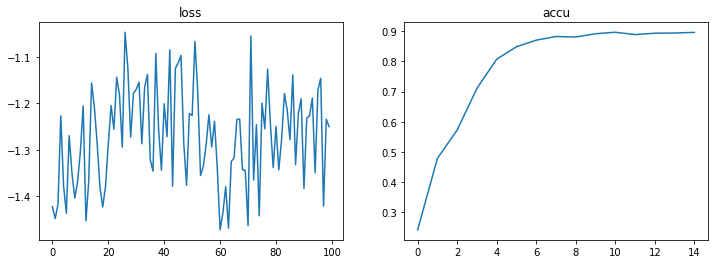


Epoch: 000 	 Accu: 0.2420 	 Time: 13.87 s
Epoch: 001 	 Accu: 0.4789 	 Time: 13.73 s
Epoch: 002 	 Accu: 0.5727 	 Time: 13.93 s
Epoch: 003 	 Accu: 0.7107 	 Time: 13.98 s
Epoch: 004 	 Accu: 0.8072 	 Time: 13.83 s
Epoch: 005 	 Accu: 0.8483 	 Time: 13.90 s
Epoch: 006 	 Accu: 0.8702 	 Time: 13.75 s
Epoch: 007 	 Accu: 0.8822 	 Time: 13.91 s
Epoch: 008 	 Accu: 0.8807 	 Time: 13.90 s
Epoch: 009 	 Accu: 0.8914 	 Time: 13.85 s
Epoch: 010 	 Accu: 0.8964 	 Time: 14.03 s
Epoch: 011 	 Accu: 0.8887 	 Time: 14.02 s
Epoch: 012 	 Accu: 0.8932 	 Time: 13.92 s
Epoch: 013 	 Accu: 0.8938 	 Time: 14.05 s


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fa56878fc80> (for post_execute):


KeyboardInterrupt: 

In [78]:
metric_dict       = logsys.initial_metric_dict(metric_list)
master_bar        = logsys.create_master_bar(300)
master_bar.set_multiply_graph(figsize=(12,4),engine=[['plot']*len(metric_list)],labels=[metric_list])
for epoch in master_bar:
    start_time = time.time()
    model.train()
    infiniter = DataSimfetcher(train_loader, device=device)
    inter_b   = logsys.create_progress_bar(len(train_loader))
    while inter_b.update_step():
        image,label= infiniter.next()
        bs,c,w,h = image.shape
        optimizer.zero_grad()
        binary     = preprocess_images(image)
        logits     = model(binary).squeeze()
        loss       = torch.nn.CrossEntropyLoss()(logits,label)
        loss.backward()
        if torch.isnan(loss):raise 
        
            
        #nn.utils.clip_grad_norm_(p, max_norm=1)
        optimizer.step()
        lses.append(loss.log().item())
        #lres.append(sum([(p.grad/p).norm() for p in model.parameters()]).log().item())
        if inter_b.now%20==0:
            master_bar.update_graph_multiply([[lses[-100:],lres[-100:]]])
    model.eval()
    prefetcher = DataSimfetcher(test_loader, device=device)
    inter_b    = logsys.create_progress_bar(len(test_loader))
    labels     = []
    logits     = []
    with torch.no_grad():
        while inter_b.update_step():
            image,label= prefetcher.next()
            binary     = preprocess_images(image)
            logit      = model(binary).squeeze()
            loss       = torch.nn.CrossEntropyLoss()(logit ,label)
            labels.append(label)
            logits.append(logit)
    labels  = torch.cat(labels)
    logits  = torch.cat(logits)
    pred_labels  = torch.argmax(logits,-1)
    accu =  torch.sum(pred_labels == labels)/len(labels)

    lres.append(accu)
    master_bar.update_graph_multiply([[lses[-100:],lres[-100:]]])
    print('\nEpoch: %.3i \t Accu: %.4f \t Time: %.2f s' %(epoch, accu.item(), time.time() - start_time),end='\r')

In [107]:
def sample(self, bs, random_start=False):
    """
    Sample images/spin configurations
    """

    device = self.tensors.device
    samples = torch.empty([bs, self.n], device=device)

    # if random_start = True, force s_1 = -1/+1 randomly
    if random_start:
        samples[:, 0] = torch.randint(2, size=(bs, ), dtype=torch.float, device=device)
    else:
        samples[:, 0] = 0.

    for idx in range(self.n - 1):
        if idx == 0:
            # sample s_2 from p(s_2 | s_1)
            embedded_data = torch.stack([samples[:, 0], 1.0 - samples[:, 0]], dim=1)  # (bs, 2)
            mats          = torch.einsum('lri,bi->blr', self.tensors[0, :, :, :] , embedded_data)
            left_vec      = mats[:, 0, :].unsqueeze(1)  # (bs, 1, D)
            logits        = torch.einsum('blr, ri->bli', left_vec,(self.tensors[1, :, :, :] )[:, 0, :]).squeeze(1)
            samples[:, 1] = torch.bernoulli(torch.softmax(logits, dim=1)[:, 0])
        else:
            # then sample s_3 from  p(s_3 | s_1, s_2) and so on
            embedded_data = torch.stack([samples[:, idx], 1.0 - samples[:, idx]], dim=1)  # (bs, 2)
            mats = torch.einsum('lri,bi->blr', self.tensors[idx, :, :, :] , embedded_data)
            left_vec = torch.bmm(left_vec, mats)  # (bs, 1, D)
            logits = torch.einsum('blr, ri->bli', left_vec,
                                  (self.tensors[idx + 1, :, :, :] )[:, 0, :]).squeeze(1)
            samples[:, idx + 1] = torch.bernoulli(torch.softmax(logits, dim=1)[:, 0])
    return samples